In [2]:
# !pip install optuna
# !pip install hyperopt

In [396]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, VotingRegressor,StackingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from scipy.optimize import minimize

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

import optuna

import xgboost as xgb

from scipy.stats import randint
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [397]:
## Import dataset

training_data = pd.read_csv('../Data/train_v9rqX0R.csv')

In [398]:
display(training_data.head())
print(training_data.shape)
# display(training_data.describe())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


(8523, 12)


In [399]:
training_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [400]:
### 
# Item checks
## Hypotheses: For an item, Item_weight,Fatcontent, item type and ItemMRP should be same

training_data.groupby(by = 'Item_Identifier', dropna=True).agg({'Item_Weight':'nunique','Item_Fat_Content':'nunique','Item_Type':'nunique','Item_MRP':'nunique','Item_Visibility':'nunique'})

,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Item_Visibility
Item_Identifier,,,,,
DRA12,1,2,1,6,5
DRA24,1,1,1,7,7
DRA59,1,1,1,8,8
DRB01,1,1,1,3,3
DRB13,1,1,1,5,5
...,...,...,...,...,...
NCZ30,1,2,1,7,7
NCZ41,1,1,1,4,5
NCZ42,1,2,1,5,5


In [401]:
## Checks
print(training_data[training_data['Item_Identifier']=='DRA12']['Item_Fat_Content'].unique())
print(training_data['Item_Fat_Content'].unique())

['Low Fat' 'LF']
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


In [402]:
low_fat = ['Low Fat', 'low fat', 'LF']
regular = ['Regular','reg']


training_data['Item_Fat_Content'] = training_data['Item_Fat_Content'].apply(
    lambda x: 'Low Fat' if x in low_fat else ('Regular' if x in regular else x)
)

training_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [403]:
## 
training_data['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [404]:
training_data_unique_item_info = training_data.groupby(by = 'Item_Identifier', dropna=True).agg({'Item_Weight':'nunique','Item_Fat_Content':'nunique','Item_Type':'nunique','Item_MRP':'nunique','Item_Visibility':'nunique'})
training_data_unique_item_info.head(2)

,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Item_Visibility
Item_Identifier,,,,,
DRA12,1,1,1,6,5
DRA24,1,1,1,7,7


In [405]:
training_data_unique_item_info[(training_data_unique_item_info['Item_Weight']>1 ) | (training_data_unique_item_info['Item_Fat_Content']>1 )| (training_data_unique_item_info['Item_Type']>1)]

,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Item_Visibility
Item_Identifier,,,,,


In [406]:
training_data[training_data['Item_Identifier'] =='FDN52']#['Item_Weight'].dropna().unique()[0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564


In [407]:
## Filling missing data: Item_Weight
# weight_not_available_items = []
for index,row in training_data.iterrows():
    if pd.isna(row['Item_Weight']):
        try:
            item_weight = training_data[training_data['Item_Identifier'] == row['Item_Identifier']]['Item_Weight'].dropna().unique()[0]
            # display(row)
            # print(row['Item_Identifier'])
            training_data.loc[index,'Item_Weight'] = item_weight
        except:
            print(row['Item_Identifier'])
            # weight_not_available_items.append(row['Item_Identifier'])

            ### For cases where item weight not present, taking avg weight of corresponding item_type
            ### Filtering on Item_type
            item_weight = training_data[training_data['Item_Type'] == row['Item_Type']]['Item_Weight'].dropna().mean()
            training_data.loc[index,'Item_Weight'] = item_weight


# training_data[training_data['Item_Identifier'].isin(weight_not_available_items)]

FDN52
FDK57
FDE52
FDQ60


In [408]:
training_data[training_data['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [409]:
### 
# Item checks
## Hypotheses: For an Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type should be same

training_data.groupby(by = 'Outlet_Identifier', dropna=True).agg({'Outlet_Establishment_Year':'nunique','Outlet_Size':'nunique','Outlet_Location_Type':'nunique','Outlet_Type':'nunique'})

,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
Outlet_Identifier,,,,
OUT010,1,0,1,1
OUT013,1,1,1,1
OUT017,1,0,1,1
OUT018,1,1,1,1
OUT019,1,1,1,1
OUT027,1,1,1,1
OUT035,1,1,1,1
OUT045,1,0,1,1
OUT046,1,1,1,1


In [410]:
### Column 1-1 check
display(training_data.groupby(by = ['Outlet_Size']).agg({'Outlet_Establishment_Year':'unique','Outlet_Location_Type':'unique','Outlet_Type':'unique'}))

display(training_data.groupby(by = ['Outlet_Location_Type']).agg({'Outlet_Size':'unique','Outlet_Establishment_Year':'unique','Outlet_Type':'unique'}))

display(training_data.groupby(by = ['Outlet_Type']).agg({'Outlet_Size':'unique','Outlet_Location_Type':'unique','Outlet_Establishment_Year':'unique'}))
display(training_data.groupby(by = ['Outlet_Establishment_Year']).agg({'Outlet_Size':'unique','Outlet_Location_Type':'unique','Outlet_Type':'unique'}))


,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type
Outlet_Size,,,
High,[1987],[Tier 3],[Supermarket Type1]
Medium,"[1999, 2009, 1985]","[Tier 1, Tier 3]","[Supermarket Type1, Supermarket Type2, Superma..."
Small,"[1997, 2004, 1985]","[Tier 1, Tier 2]","[Supermarket Type1, Grocery Store]"


,Outlet_Size,Outlet_Establishment_Year,Outlet_Type
Outlet_Location_Type,,,
Tier 1,"[Medium, Small]","[1999, 1997, 1985]","[Supermarket Type1, Grocery Store]"
Tier 2,"[nan, Small]","[2002, 2007, 2004]",[Supermarket Type1]
Tier 3,"[Medium, nan, High]","[2009, 1998, 1987, 1985]","[Supermarket Type2, Grocery Store, Supermarket..."


,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year
Outlet_Type,,,
Grocery Store,"[nan, Small]","[Tier 3, Tier 1]","[1998, 1985]"
Supermarket Type1,"[Medium, High, nan, Small]","[Tier 1, Tier 3, Tier 2]","[1999, 1987, 2002, 2007, 1997, 2004]"
Supermarket Type2,[Medium],[Tier 3],[2009]
Supermarket Type3,[Medium],[Tier 3],[1985]


,Outlet_Size,Outlet_Location_Type,Outlet_Type
Outlet_Establishment_Year,,,
1985,"[Medium, Small]","[Tier 3, Tier 1]","[Supermarket Type3, Grocery Store]"
1987,[High],[Tier 3],[Supermarket Type1]
1997,[Small],[Tier 1],[Supermarket Type1]
1998,[nan],[Tier 3],[Grocery Store]
1999,[Medium],[Tier 1],[Supermarket Type1]
2002,[nan],[Tier 2],[Supermarket Type1]
2004,[Small],[Tier 2],[Supermarket Type1]
2007,[nan],[Tier 2],[Supermarket Type1]
2009,[Medium],[Tier 3],[Supermarket Type2]


In [411]:
## Filling missing data: Outlet_size
outlet_size_not_available_items = []
for index,row in training_data.iterrows():
    if pd.isna(row['Outlet_Size']):
        try:
            outlet_size = training_data[training_data['Outlet_Identifier'] == row['Outlet_Identifier']]['Outlet_Size'].dropna().unique()[0]
            # display(row)
            # print(row['Item_Identifier'])
            training_data.loc[index,'Outlet_Size'] = outlet_size
        except:
            # print(row['Outlet_Size'])
            outlet_size_not_available_items.append(row['Outlet_Identifier'])


training_data[(training_data['Outlet_Identifier'].isin(outlet_size_not_available_items)) & (training_data['Outlet_Size'].isna())]['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [412]:
training_data[(training_data['Outlet_Identifier'].isin(outlet_size_not_available_items)) & (training_data['Outlet_Size'].isna())].shape#['Outlet_Identifier'].unique()

(2410, 12)

In [413]:
print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Type'].unique())
print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Location_Type'].unique())
print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Establishment_Year'].unique())


# print(training_data[training_data['Outlet_Identifier']=='OUT045']['Outlet_Type'].unique())
# print(training_data[training_data['Outlet_Identifier']=='OUT045']['Outlet_Location_Type'].unique())
# print(training_data[training_data['Outlet_Identifier']=='OUT045']['Outlet_Establishment_Year'].unique())


# print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Type'].unique())
# print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Location_Type'].unique())
# print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Establishment_Year'].unique())

['Grocery Store']
['Tier 3']
[1998]


In [414]:
print(training_data[(training_data['Outlet_Type'] == 'Grocery Store') ]['Outlet_Size'].unique()) ## & (training_data['Outlet_Establishment_Year'] == 1998)  & (training_data['Outlet_Location_Type'] == 'Tier 3')
print(training_data[(training_data['Outlet_Location_Type'] == 'Tier 3') ]['Outlet_Size'].unique())
print(training_data[(training_data['Outlet_Establishment_Year'] == 1998) ]['Outlet_Size'].unique())

[nan 'Small']
['Medium' nan 'High']
[nan]


In [415]:
### Alternative because there is no logic between outlet size and outlet type, locationtyype etc
training_data['Outlet_Size'].fillna(training_data['Outlet_Size'].mode()[0], inplace = True)

In [416]:
print(training_data[training_data['Outlet_Identifier']=='OUT010']['Outlet_Size'].unique())
print(training_data[training_data['Outlet_Identifier']=='OUT017']['Outlet_Size'].unique())
print(training_data[training_data['Outlet_Identifier']=='OUT045']['Outlet_Size'].unique())


['Medium']
['Medium']
['Medium']


In [417]:
#### Item_visibility is zero, replacing it with median value of item identifier
print(training_data[training_data['Item_Visibility']==0].shape)

for index,row in training_data.iterrows():
    if row['Item_Visibility']==0:
        try:
            item_visibility = training_data[(training_data['Item_Identifier'] == row['Item_Identifier']) & (training_data['Item_Visibility']>0)]['Item_Visibility'].median()
            if item_visibility is np.nan:
                item_visibility = test_data[(test_data['Item_Type'] == row['Item_Type']) & (test_data['Item_Visibility']>0)]['Item_Visibility'].median()
            
            training_data.loc[index,'Item_Visibility'] = item_visibility
            
        except:
            pass

print(training_data[training_data['Item_Visibility']==0].shape)

(526, 12)
(0, 12)


In [418]:
training_data[training_data['Item_Visibility']==0]
# training_data[training_data['Item_Identifier']=='FDX07']


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


#### Checking skewness

-0.07479057334672161


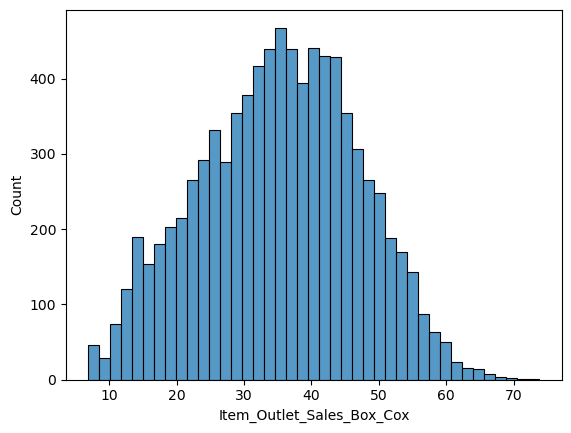

In [419]:
from scipy import stats
# training_data['IV_boxcox'], lambda_val = stats.boxcox(training_data['Item_Visibility']+1)
# sns.histplot(training_data['IV_boxcox'])
# print(training_data['IV_boxcox'].skew())

training_data['Item_Outlet_Sales_Box_Cox'], lambda_val_item_outlet_sales = stats.boxcox(training_data['Item_Outlet_Sales']+1)
sns.histplot(training_data['Item_Outlet_Sales_Box_Cox'])
print(training_data['Item_Outlet_Sales_Box_Cox'].skew())

In [420]:
# numerical_cols = ['Item_Visibility',] ## , 'Item_Outlet_Sales'  'Item_MRP' #'Item_Weight', 
# df_temp = training_data[numerical_cols]
# df_temp.boxplot()

<Axes: xlabel='Item_Visibility', ylabel='Count'>

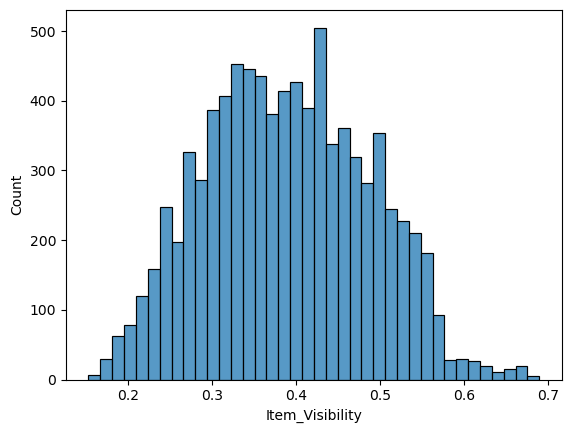

In [421]:
# sns.histplot(np.log1p(training_data['Item_Visibility']))
# sns.histplot(np.sqrt(training_data['Item_Visibility']))
sns.histplot(np.cbrt(training_data['Item_Visibility']))
# sns.histplot(training_data['Item_Visibility'])


In [422]:
# sns.histplot(np.log1p(training_data['Item_Outlet_Sales']))
# sns.histplot(np.sqrt(training_data['Item_Outlet_Sales']))
# sns.histplot(np.cbrt(training_data['Item_Outlet_Sales']))

In [423]:
print(np.cbrt(training_data['Item_Visibility']).skew())
print(np.sqrt(training_data['Item_Visibility']).skew())
print(training_data['Item_Visibility'].skew())

# print(np.cbrt(training_data['Item_Outlet_Sales']).skew())
# print(np.sqrt(training_data['Item_Outlet_Sales']).skew())
# print(np.log1p(training_data['Item_Outlet_Sales']).skew())
# print(training_data['Item_Outlet_Sales_Box_Cox'].skew())


0.13099372608648385
0.39616836394790106
1.2096587765370248


In [424]:
# training_data['Item_Visibility_cbrt'] = np.cbrt(training_data['Item_Visibility'])

In [425]:
training_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Outlet_Sales_Box_Cox'],
      dtype='object')

### Transformations
    # 1. Item_Outlet_Sales: BOX-COX
    # 2. Item_Visibility: sqrt

In [426]:
training_data['Outlet_Establishment_Year'].max()

2009

In [427]:
training_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Outlet_Sales_Box_Cox    0
dtype: int64

### categorizing item identifier

In [428]:
### categorizing item identifier
training_data['Item_Identifier_Name'] = training_data['Item_Identifier'].apply(lambda x: x[0:2])
training_data['Item_Identifier_Name'] = training_data['Item_Identifier_Name'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})


In [429]:
training_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Item_Identifier_Name
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,46.821726,Food
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,20.917893,Drinks
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,37.830717,Food
3,FDX07,19.200,Regular,0.022934,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,25.420372,Food
4,NCD19,8.930,Low Fat,0.013254,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,28.577994,Non_Consumable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,41.987935,Food
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,Supermarket Type1,549.2850,22.743570,Food
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,30.618736,Non_Consumable
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,36.070753,Food


In [430]:
## Converting establishment year to year
training_data['Outlet_age'] = 2025 - training_data['Outlet_Establishment_Year']
training_data.drop(columns = ['Outlet_Establishment_Year'],inplace = True)

In [78]:
training_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Item_Identifier_Name,Outlet_age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,46.821726,Food,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,20.917893,Drinks,16


In [432]:
# from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
le_size = LabelEncoder()
le_location = LabelEncoder()

# Fit and transform Outlet_Size
training_data['Outlet_Size_Encoded'] = le_size.fit_transform(training_data['Outlet_Size'])

# Fit and transform Outlet_Location_Type
training_data['Outlet_Location_Encoded'] = le_location.fit_transform(training_data['Outlet_Location_Type'])

In [433]:
training_data['Outlet_MRP_Rank'] = training_data.groupby('Outlet_Identifier')['Item_MRP'].transform(lambda x: x.rank(pct=True))

training_data['Total_Unique_Items_Outlet'] = training_data.groupby('Outlet_Identifier')['Item_Identifier'].transform('nunique')

training_data['Avg_Item_MRP_Outlet_Type'] = training_data.groupby('Outlet_Type')['Item_MRP'].transform('mean')

training_data['Item_Visibility_Adjusted'] = training_data['Item_Visibility'] / training_data['Item_Visibility'].max()

training_data['Price_per_Unit_Weight'] = training_data['Item_MRP'] / training_data['Item_Weight']
training_data['Price_per_Unit_Weight'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle division errors
training_data['Price_per_Unit_Weight'].fillna(training_data['Price_per_Unit_Weight'].median(), inplace=True)  # Fill missing values


training_data['MRP_Outlet_Size'] = training_data['Item_MRP'] * training_data['Outlet_Size_Encoded']


item_demand = training_data['Item_Identifier'].value_counts().to_dict()
training_data['Item_Demand_Score'] = training_data['Item_Identifier'].map(item_demand)

# training_data['Visibility_MRP'] = training_data['Item_Visibility'] * training_data['Item_MRP']

training_data['MRP_per_Visibility'] = training_data['Item_MRP'] / (training_data['Item_Visibility'] + 1e-9)


# Display the first few rows with new features
training_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Item_Identifier_Name,Outlet_age,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,Outlet_Size_Encoded,Outlet_Location_Encoded,MRP_Outlet_Size,Item_Demand_Score,MRP_per_Visibility
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,46.821726,Food,26,0.948387,930,141.213894,0.048866,26.861204,1,0,249.8092,8,15567.052954
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,20.917893,Drinks,16,0.075431,928,141.678634,0.058705,8.153581,1,2,48.2692,6,2503.820763
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,37.830717,Food,26,0.498925,930,141.213894,0.051037,8.092457,1,0,141.6180,7,8449.723020
3,FDX07,19.20,Regular,0.022934,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,25.420372,Food,27,0.726126,555,140.294688,0.069839,9.484115,1,2,182.0950,6,7939.798195
4,NCD19,8.93,Low Fat,0.013254,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,28.577994,Non_Consumable,38,0.103541,932,141.213894,0.040360,6.031512,0,2,0.0000,6,4063.803834


<Axes: >

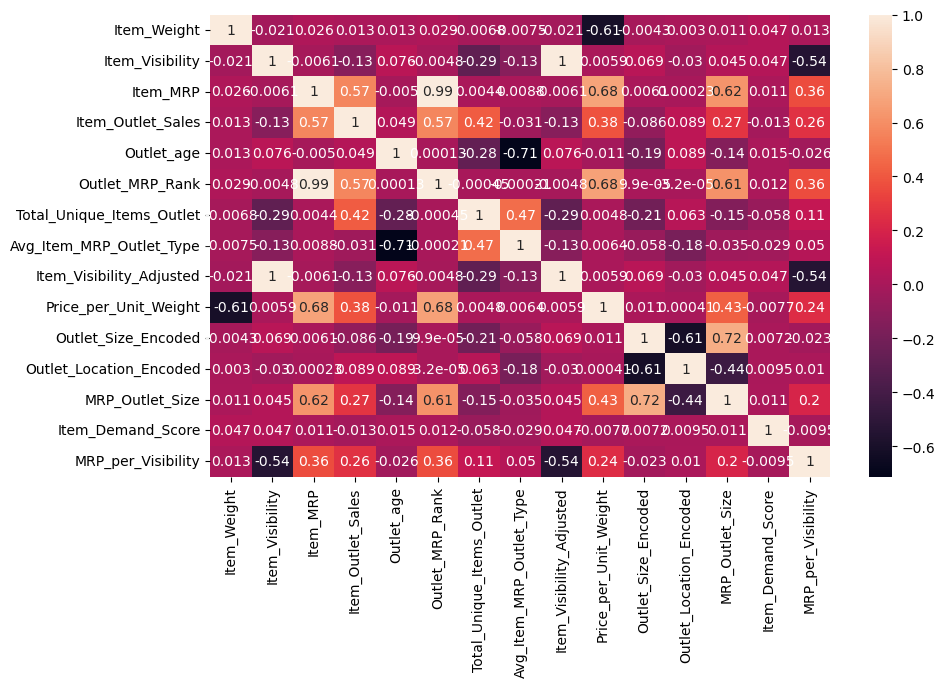

In [435]:
numeric_features = training_data.select_dtypes(include=['number']).drop(columns = ['Item_Outlet_Sales_Box_Cox'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features.corr(),annot=True)

### One -Hot encoding of Categorical columns

In [88]:
# Will do after Clustering
# ## One -Hot encoding of Categorical columns
# categorical_columns = [
#     'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 
#     'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_Name'
# ]

# training_data_encoded = pd.get_dummies(training_data, columns=categorical_columns, drop_first=True)

# one_hot_columns = training_data_encoded.columns.difference(training_data.columns)
# training_data_encoded[one_hot_columns] = training_data_encoded[one_hot_columns].astype(int)

In [90]:
# training_data_encoded

[[1.         0.55250984]
 [0.55250984 1.        ]]


<Axes: xlabel='Outlet_MRP_Rank', ylabel='Item_Outlet_Sales_Box_Cox'>

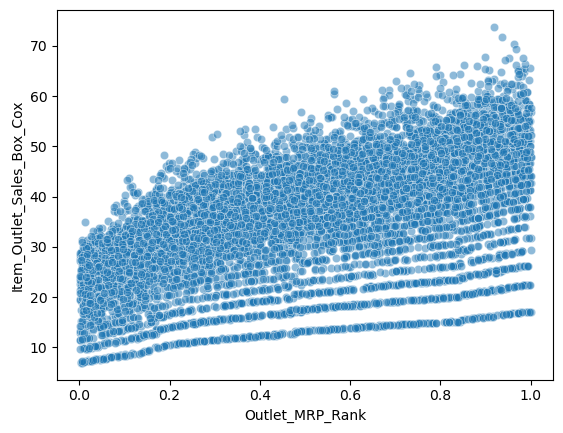

In [94]:
import seaborn as sns
print(np.corrcoef(training_data['Outlet_MRP_Rank'],training_data['Item_Outlet_Sales_Box_Cox']))
sns.scatterplot(x=training_data['Outlet_MRP_Rank'], y=training_data['Item_Outlet_Sales_Box_Cox'], alpha=0.5)

In [96]:
print(np.corrcoef(training_data['Item_Visibility_cbrt'],training_data['Item_Outlet_Sales']))
sns.scatterplot(x=training_data['Item_Visibility_cbrt'], y=training_data['Item_Outlet_Sales'], alpha=0.5)

KeyError: 'Item_Visibility_cbrt'

In [98]:
# training_data_encoded['Visibility_MRP'] = training_data_encoded['Item_MRP']*training_data_encoded['Item_Visibility_sqrt']

In [100]:
# print(np.corrcoef(training_data_encoded['Visibility_MRP'],training_data_encoded['Item_Outlet_Sales_Box_Cox']))
# sns.scatterplot(x=training_data_encoded['Visibility_MRP'], y=training_data_encoded['Item_Outlet_Sales_Box_Cox'], alpha=0.5)

<Axes: >

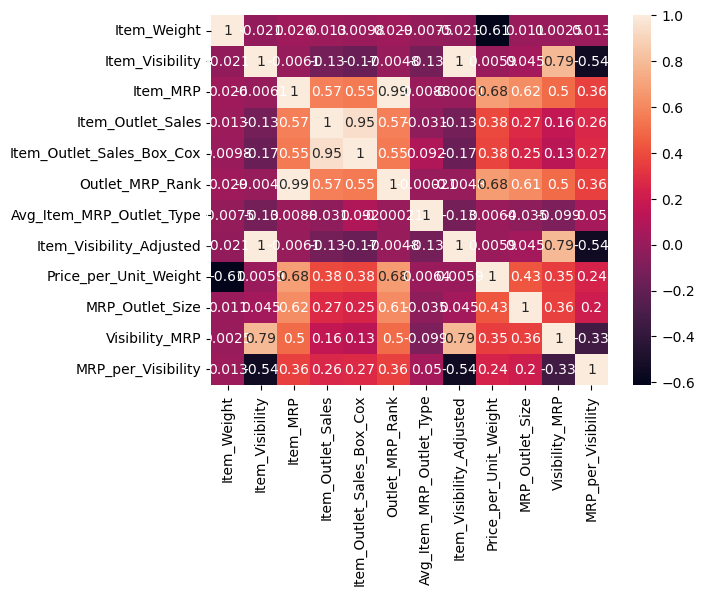

In [102]:
sns.heatmap(training_data.select_dtypes(include='float64').corr(),annot=True)

### Try
1. Check for boxplots for the categorical items vs sales
2. Skewness of numerical variables -  can do some transformations like log/boxcox to make them normal
3. Heatmap to get correlation. Apply encoding to get numerical values
4. we can make some interaction terms
5. apply gradient boosting, light gbm
6. clustering


## Preparing test data

In [436]:
test_data = pd.read_csv('../Data/test_AbJTz2l.csv')
test_data.value_counts("Item_Identifier")

Item_Identifier
DRF48    8
FDK57    8
FDZ50    8
FDN52    8
NCS41    8
        ..
NCB31    1
FDH33    1
FDB36    1
FDS16    1
FDI14    1
Name: count, Length: 1543, dtype: int64

In [437]:
test_data[test_data["Item_Identifier"]=="NCL31"]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type


In [438]:
training_data.value_counts("Item_Identifier")

Item_Identifier
FDG33    10
FDW13    10
NCL31     9
FDX04     9
NCQ06     9
         ..
FDN52     1
FDC23     1
FDT35     1
DRF48     1
FDE52     1
Name: count, Length: 1559, dtype: int64

In [439]:
### Transforming test data



####
low_fat = ['Low Fat', 'low fat', 'LF']
regular = ['Regular','reg']

test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x in low_fat else ('Regular' if x in regular else x))

##
## Filling missing data: Item_Weight
for index,row in test_data.iterrows():
    if pd.isna(row['Item_Weight']):
        try:
            item_weight = test_data[test_data['Item_Identifier'] == row['Item_Identifier']]['Item_Weight'].dropna().unique()[0]
            test_data.loc[index,'Item_Weight'] = item_weight
        except:
            # print(row['Item_Identifier'])
            item_weight = test_data[test_data['Item_Type'] == row['Item_Type']]['Item_Weight'].dropna().mean()
            test_data.loc[index,'Item_Weight'] = item_weight


# test_data[test_data['Item_Identifier'].isin(weight_not_available_items)]
##
### Alternative because there is no logic between outlet size and outlet type, locationtyype etc
test_data['Outlet_Size'].fillna(test_data['Outlet_Size'].mode()[0], inplace = True)

###### Item_visibility is zero, replacing it with median value of item identifier
# print(test_data[test_data['Item_Visibility']==0].shape)

for index,row in test_data.iterrows():
    if (row['Item_Visibility']==0) or (pd.isna(row['Item_Visibility'])):
        try:
            item_visibility = test_data[(test_data['Item_Identifier'] == row['Item_Identifier']) & (test_data['Item_Visibility']>0)]['Item_Visibility'].median()
            if item_visibility is np.nan:
                item_visibility = test_data[(test_data['Item_Type'] == row['Item_Type']) & (test_data['Item_Visibility']>0)]['Item_Visibility'].median()
                
            test_data.loc[index,'Item_Visibility'] = item_visibility
        except:
            print(item_visibility)




# print(test_data[test_data['Item_Visibility']==0].shape)
#########
# test_data['Item_Visibility_cbrt'] = np.cbrt(test_data['Item_Visibility'])


## Converting establishment year to year
test_data['Outlet_age'] = 2025 - test_data['Outlet_Establishment_Year']
test_data.drop(columns = ['Outlet_Establishment_Year'],inplace = True)
##
### categorizing item identifier
test_data['Item_Identifier_Name'] = test_data['Item_Identifier'].apply(lambda x: x[0:2])
test_data['Item_Identifier_Name'] = test_data['Item_Identifier_Name'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})


######### Will do after labelling the test set
# ## One -Hot encoding of Categorical columns
# categorical_columns = [
#     'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 
#     'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_Name'
# ]

# test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# one_hot_columns = test_data_encoded.columns.difference(training_data.columns)
# test_data_encoded[one_hot_columns] = test_data_encoded[one_hot_columns].astype(int)


In [440]:
# Apply same encoding to test data
test_data['Outlet_Size_Encoded'] = le_size.transform(test_data['Outlet_Size'])
test_data['Outlet_Location_Encoded'] = le_location.transform(test_data['Outlet_Location_Type'])
test_data['Outlet_MRP_Rank'] = test_data.groupby('Outlet_Identifier')['Item_MRP'].transform(lambda x: x.rank(pct=True))

test_data['Total_Unique_Items_Outlet'] = test_data.groupby('Outlet_Identifier')['Item_Identifier'].transform('nunique')

test_data['Avg_Item_MRP_Outlet_Type'] = test_data.groupby('Outlet_Type')['Item_MRP'].transform('mean')

test_data['Item_Visibility_Adjusted'] = test_data['Item_Visibility'] / test_data['Item_Visibility'].max()

test_data['Price_per_Unit_Weight'] = test_data['Item_MRP'] / test_data['Item_Weight']
test_data['Price_per_Unit_Weight'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle division errors
test_data['Price_per_Unit_Weight'].fillna(test_data['Price_per_Unit_Weight'].median(), inplace=True)  # Fill missing values


test_data['MRP_Outlet_Size'] = test_data['Item_MRP'] * test_data['Outlet_Size_Encoded']


item_demand = test_data['Item_Identifier'].value_counts().to_dict()
test_data['Item_Demand_Score'] = test_data['Item_Identifier'].map(item_demand)

test_data['Visibility_MRP'] = test_data['Item_Visibility'] * test_data['Item_MRP']

test_data['MRP_per_Visibility'] = test_data['Item_MRP'] / (test_data['Item_Visibility'] + 1e-9)


# Display the first few rows with new features
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_age,Item_Identifier_Name,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,26,Food,1,0,0.341935,620,140.711409,0.023374,5.198178,107.8622,7,0.815960,14258.364060
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.199352,617,140.711409,0.118737,10.520458,87.3198,6,3.355497,2272.315283
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,Medium,Tier 3,Grocery Store,27,Non_Consumable,1,2,0.935135,370,141.960824,0.307674,16.558479,241.7538,4,24.072612,2427.858608
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.559157,617,140.711409,0.047548,21.193985,155.0340,3,2.385724,10074.735544
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,40,Food,1,2,0.900641,624,142.826241,0.366458,17.222794,234.2300,4,27.779517,1974.969248


In [441]:
test_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Outlet_age                   0
Item_Identifier_Name         0
Outlet_Size_Encoded          0
Outlet_Location_Encoded      0
Outlet_MRP_Rank              0
Total_Unique_Items_Outlet    0
Avg_Item_MRP_Outlet_Type     0
Item_Visibility_Adjusted     0
Price_per_Unit_Weight        0
MRP_Outlet_Size              0
Item_Demand_Score            0
Visibility_MRP               0
MRP_per_Visibility           0
dtype: int64

## Modelling


### 1. Clustering

In [201]:
obj_feat = training_data.select_dtypes(include=['object']).drop(columns=['Outlet_Size','Outlet_Location_Type']).columns
obj_feat

KeyError: "['Outlet_Size', 'Outlet_Location_Type'] not found in axis"

In [203]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score


for i in obj_feat:
    training_data[i+'_cat'] = training_data[i].astype('category').cat.codes
training_data = training_data.drop(columns=['Outlet_Size','Outlet_Location_Type'])


training_data.head()

KeyError: "['Outlet_Size', 'Outlet_Location_Type'] not found in axis"

In [205]:
training_data.columns


Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Type',
       'Item_Outlet_Sales', 'Item_Outlet_Sales_Box_Cox',
       'Item_Identifier_Name', 'Outlet_age', 'Outlet_Size_Encoded',
       'Outlet_Location_Encoded', 'Outlet_MRP_Rank',
       'Total_Unique_Items_Outlet', 'Avg_Item_MRP_Outlet_Type',
       'Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'Item_Demand_Score', 'Visibility_MRP', 'MRP_per_Visibility',
       'KMeans_Cluster', 'Item_Identifier_cat', 'Item_Fat_Content_cat',
       'Item_Type_cat', 'Outlet_Identifier_cat', 'Outlet_Type_cat',
       'Item_Identifier_Name_cat'],
      dtype='object')

In [130]:
from sklearn.preprocessing import StandardScaler

# Selecting outlet-related features
outlet_features = [
    'Outlet_Size_Encoded', 'Outlet_Location_Encoded', 'Outlet_age', 
    'Total_Unique_Items_Outlet', 'Avg_Item_MRP_Outlet_Type']

# Selecting item-related features
item_features = [
    'Item_Weight', 'Item_Fat_Content_cat', 'Item_MRP','Price_per_Unit_Weight', 'Item_Demand_Score', 'MRP_per_Visibility'
]

# Selecting combined features (Outlet + Item)
combined_features = outlet_features + item_features

# Standardizing data
scaler = StandardScaler()
outlet_scaled = scaler.fit_transform(training_data[outlet_features])
item_scaled = scaler.fit_transform(training_data[item_features])
combined_scaled = scaler.fit_transform(training_data[combined_features])


In [253]:
# # Feature Scaling
# scaler = StandardScaler()
# # X_scaled1 = scaler.fit_transform(agg_df[['Sales_Mean', 'Sales_Sum', 'MRP_Mean', 'Visibility_Mean']])
# X_scaled = scaler.fit_transform(training_data[['Item_Weight','Item_Visibility','Item_MRP','Item_Type_cat','Outlet_Type_cat', 'Outlet_Location_Type_cat']])
# # X_scaled2 = scaler.fit_transform(training_data[['Item_Weight','Item_Visibility','Item_MRP','Item_Type_cat']])


# # 1. K-Means Clustering
# # wcss = []
# # for k in range(2, 10):
# #     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
# #     kmeans.fit(X_scaled)
# #     wcss.append(kmeans.inertia_)

# # plt.plot(range(2, 10), wcss, marker='o')
# # plt.xlabel('Number of Clusters')
# # plt.ylabel('WCSS')
# # plt.title('Elbow Method for Optimal K')
# # plt.show()

# # # Fit K-Means with optimal K (say K=4)
# # kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
# # training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled1)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))

# # kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# # training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled1)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))

# ##########  Best with 4 ctegories
# kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
# training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))

# # # Fit K-Means with optimal K (say K=4)
# # kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
# # training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled2)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))

# # kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# # training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled2)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))

# # kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
# # training_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled2)
# # print(evaluate_clustering(X_scaled, training_data['KMeans_Cluster']))


                    


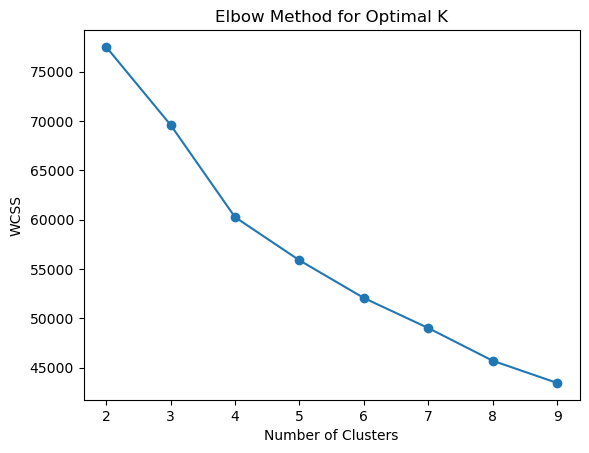

In [132]:
from sklearn.cluster import KMeans

# Find optimal clusters using the Elbow Method
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(combined_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
import matplotlib.pyplot as plt
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()



In [134]:
# Apply K-Means with optimal K (say K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
training_data['KMeans_Cluster'] = kmeans.fit_predict(combined_scaled)


In [136]:
# 2. Hierarchical Clustering
# linked = linkage(combined_scaled, method='ward')
# plt.figure(figsize=(10, 5))
# dendrogram(linked)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.show()

# # Assign clusters
# training_data['Hierarchical_Cluster'] = fcluster(linked, t=3, criterion='maxclust')
# training_data


In [138]:
# 3. DBSCAN Clustering
# dbscan = DBSCAN(eps=1.5, min_samples=5).fit(X_scaled) ###eps = 1.1 1.3
# training_data['DBSCAN_Cluster'] = dbscan.labels_

# 4. Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
training_data['GMM_Cluster'] = gmm.fit_predict(combined_scaled)


In [140]:

# Evaluate clustering methods
def evaluate_clustering(X, labels):
    if len(set(labels)) > 1:  # Avoid errors when all samples are in one cluster
        return {
            'Silhouette Score': silhouette_score(X, labels),
            'Davies-Bouldin Index': davies_bouldin_score(X, labels)
        }
    else:
        return {'Silhouette Score': -1, 'Davies-Bouldin Index': np.inf}

evaluations = {
    'KMeans': evaluate_clustering(combined_scaled, training_data['KMeans_Cluster']),
    # 'Hierarchical': evaluate_clustering(X_scaled, training_data['Hierarchical_Cluster']),
    # 'DBSCAN': evaluate_clustering(X_scaled, training_data['DBSCAN_Cluster']),
    'GMM': evaluate_clustering(combined_scaled, training_data['GMM_Cluster'])
}

eval = pd.DataFrame(evaluations)



In [142]:
eval

,KMeans,GMM
Silhouette Score,0.193538,0.169773
Davies-Bouldin Index,1.780221,1.897832


In [144]:
print(training_data['KMeans_Cluster'].value_counts())
# print(training_data['Hierarchical_Cluster'].unique())
# print(training_data['DBSCAN_Cluster'].unique())
print(training_data['GMM_Cluster'].value_counts())


KMeans_Cluster
2    3482
1    2125
3    1835
0    1081
Name: count, dtype: int64
GMM_Cluster
1    2929
2    2644
3    1867
0    1083
Name: count, dtype: int64


In [146]:
training_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Type',
       'Item_Outlet_Sales', 'Item_Outlet_Sales_Box_Cox',
       'Item_Identifier_Name', 'Outlet_age', 'Outlet_Size_Encoded',
       'Outlet_Location_Encoded', 'Outlet_MRP_Rank',
       'Total_Unique_Items_Outlet', 'Avg_Item_MRP_Outlet_Type',
       'Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'Item_Demand_Score', 'Visibility_MRP', 'MRP_per_Visibility',
       'Item_Identifier_cat', 'Item_Fat_Content_cat', 'Item_Type_cat',
       'Outlet_Identifier_cat', 'Outlet_Type_cat', 'Item_Identifier_Name_cat',
       'KMeans_Cluster', 'GMM_Cluster'],
      dtype='object')

In [148]:
# Finalizing KMEans
### Dropping other cluster scores and category columns created for clustering

training_data.drop(columns = ['Item_Identifier_cat', 'Item_Fat_Content_cat', 'Item_Type_cat',
       'Outlet_Identifier_cat', 'Outlet_Type_cat', 'Item_Identifier_Name_cat','GMM_Cluster'],inplace = True)

In [207]:
training_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Item_Identifier_Name,Outlet_age,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,KMeans_Cluster,Item_Identifier_cat,Item_Fat_Content_cat,Item_Type_cat,Outlet_Identifier_cat,Outlet_Type_cat,Item_Identifier_Name_cat
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Supermarket Type1,3735.1380,46.821726,Food,26,1,0,0.948387,930,141.213894,0.048866,26.861204,249.8092,8,4.008763,15567.052954,1,156,0,4,9,1,1
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Supermarket Type2,443.4228,20.917893,Drinks,16,1,2,0.075431,928,141.678634,0.058705,8.153581,48.2692,6,0.930544,2503.820763,2,8,1,14,3,2,0
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Supermarket Type1,2097.2700,37.830717,Food,26,1,0,0.498925,930,141.213894,0.051037,8.092457,141.6180,7,2.373528,8449.723020,2,662,0,10,9,1,1
3,FDX07,19.20,Regular,0.022934,Fruits and Vegetables,182.0950,OUT010,Grocery Store,732.3800,25.420372,Food,27,1,2,0.726126,555,140.294688,0.069839,9.484115,182.0950,6,4.176251,7939.798195,0,1121,1,6,0,0,1
4,NCD19,8.93,Low Fat,0.013254,Household,53.8614,OUT013,Supermarket Type1,994.7052,28.577994,Non_Consumable,38,0,2,0.103541,932,141.213894,0.040360,6.031512,0.0000,6,0.713876,4063.803834,3,1297,0,9,1,1,2


In [152]:
## One -Hot encoding of Categorical columns
categorical_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type', 'Item_Identifier_Name']

training_data_encoded = pd.get_dummies(training_data, columns=categorical_columns, drop_first=True)

one_hot_columns = training_data_encoded.columns.difference(training_data.columns)
training_data_encoded[one_hot_columns] = training_data_encoded[one_hot_columns].astype(int)

In [209]:
training_data_encoded

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Outlet_age,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,KMeans_Cluster,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Name_Food,Item_Identifier_Name_Non_Consumable
0,FDA15,9.300,0.016047,249.8092,3735.1380,46.821726,26,1,0,0.948387,930,141.213894,0.048866,26.861204,249.8092,8,4.008763,15567.052954,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,DRC01,5.920,0.019278,48.2692,443.4228,20.917893,16,1,2,0.075431,928,141.678634,0.058705,8.153581,48.2692,6,0.930544,2503.820763,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,FDN15,17.500,0.016760,141.6180,2097.2700,37.830717,26,1,0,0.498925,930,141.213894,0.051037,8.092457,141.6180,7,2.373528,8449.723020,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,FDX07,19.200,0.022934,182.0950,732.3800,25.420372,27,1,2,0.726126,555,140.294688,0.069839,9.484115,182.0950,6,4.176251,7939.798195,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,NCD19,8.930,0.013254,53.8614,994.7052,28.577994,38,0,2,0.103541,932,141.213894,0.040360,6.031512,0.0000,6,0.713876,4063.803834,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0.056783,214.5218,2778.3834,41.987935,38,0,2,0.846567,932,141.213894,0.172914,31.248623,0.0000,8,12.181275,3777.897022,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
8519,FDS36,8.380,0.046982,108.1570,549.2850,22.743570,23,1,1,0.336921,929,141.213894,0.143069,12.906563,108.1570,6,5.081479,2302.073350,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
8520,NCJ29,10.600,0.035186,85.1224,1193.1136,30.618736,21,2,1,0.184946,930,141.213894,0.107148,8.030415,170.2448,6,2.995140,2419.193485,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
8521,FDN46,7.210,0.145221,103.1332,1845.5976,36.070753,16,1,2,0.310884,928,141.678634,0.442219,14.304189,103.1332,6,14.977070,710.182761,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [211]:
training_data_encoded.shape

(8523, 49)

In [213]:
#### Labelling test set

In [215]:
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_age,Item_Identifier_Name,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,26,Food,1,0,0.341935,620,140.711409,0.023374,5.198178,107.8622,7,0.815960,14258.364060
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.199352,617,140.711409,0.118737,10.520458,87.3198,6,3.355497,2272.315283
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,Medium,Tier 3,Grocery Store,27,Non_Consumable,1,2,0.935135,370,141.960824,0.307674,16.558479,241.7538,4,24.072612,2427.858608
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.559157,617,140.711409,0.047548,21.193985,155.0340,3,2.385724,10074.735544
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,40,Food,1,2,0.900641,624,142.826241,0.366458,17.222794,234.2300,4,27.779517,1974.969248


In [217]:
### Preparing test set
# Encoding categorical features
# test_data['Item_Identifier_cat'] = test_data['Item_Identifier'].astype('category').cat.codes
# test_data['Outlet_Identifier_cat'] = test_data['Outlet_Identifier'].astype('category').cat.codes
# test_data['Item_Type_cat'] = test_data['Item_Type'].astype('category').cat.codes
# test_data['Outlet_Type_cat'] = test_data['Outlet_Type'].astype('category').cat.codes
# test_data['Outlet_Location_Type_cat'] = test_data['Outlet_Location_Type'].astype('category').cat.codes

# scaler = StandardScaler()
# X_test_scaled = scaler.fit_transform(test_data[['Item_Weight','Item_Visibility','Item_MRP','Item_Type_cat', 'Outlet_Type_cat','Outlet_Location_Type_cat']])

for i in obj_feat:
    test_data[i+'_cat'] = test_data[i].astype('category').cat.codes
# test_data = test_data.drop(columns=['Outlet_Size','Outlet_Location_Type'])


test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_age,Item_Identifier_Name,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,Item_Identifier_cat,Item_Fat_Content_cat,Item_Type_cat,Outlet_Identifier_cat,Outlet_Type_cat,Item_Identifier_Name_cat
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,26,Food,1,0,0.341935,620,140.711409,0.023374,5.198178,107.8622,7,0.815960,14258.364060,1103,0,13,9,1,1
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.199352,617,140.711409,0.118737,10.520458,87.3198,6,3.355497,2272.315283,1067,1,4,2,1,1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,Medium,Tier 3,Grocery Store,27,Non_Consumable,1,2,0.935135,370,141.960824,0.307674,16.558479,241.7538,4,24.072612,2427.858608,1406,0,11,0,0,2
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Medium,Tier 2,Supermarket Type1,18,Food,1,1,0.559157,617,140.711409,0.047548,21.193985,155.0340,3,2.385724,10074.735544,809,0,13,2,1,1
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,40,Food,1,2,0.900641,624,142.826241,0.366458,17.222794,234.2300,4,27.779517,1974.969248,1184,1,4,5,3,1


In [219]:
# Selecting outlet-related features
X_test_scaled = scaler.transform(test_data[combined_features])
test_data['KMeans_Cluster'] = kmeans.predict(X_test_scaled)

In [221]:
# test_clusters = kmeans.predict(X_test_scaled)
# test_data['KMeans_Cluster'] = test_clusters

In [223]:
training_data['KMeans_Cluster'].unique()

array([1, 2, 0, 3])

In [225]:
training_data['KMeans_Cluster'].value_counts()

KMeans_Cluster
2    3482
1    2125
3    1835
0    1081
Name: count, dtype: int64

In [227]:
test_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Outlet_age',
       'Item_Identifier_Name', 'Outlet_Size_Encoded',
       'Outlet_Location_Encoded', 'Outlet_MRP_Rank',
       'Total_Unique_Items_Outlet', 'Avg_Item_MRP_Outlet_Type',
       'Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'Item_Demand_Score', 'Visibility_MRP', 'MRP_per_Visibility',
       'Item_Identifier_cat', 'Item_Fat_Content_cat', 'Item_Type_cat',
       'Outlet_Identifier_cat', 'Outlet_Type_cat', 'Item_Identifier_Name_cat',
       'KMeans_Cluster'],
      dtype='object')

In [229]:
# test_data.drop(columns = ['Outlet_Location_Type_cat','Item_Identifier_cat','Outlet_Identifier_cat','Outlet_Type_cat','Item_Type_cat'],inplace = True)
test_data.drop(columns = ['Item_Identifier_cat', 'Item_Fat_Content_cat', 'Item_Type_cat',
       'Outlet_Identifier_cat', 'Outlet_Type_cat', 'Item_Identifier_Name_cat','Outlet_Location_Type','Outlet_Size_Encoded','Outlet_Size'],inplace = True)


In [237]:
test_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Type,Outlet_age,Item_Identifier_Name,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,KMeans_Cluster
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Supermarket Type1,26,Food,0,0.341935,620,140.711409,0.023374,5.198178,107.8622,7,0.815960,14258.364060,0
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,Supermarket Type1,18,Food,1,0.199352,617,140.711409,0.118737,10.520458,87.3198,6,3.355497,2272.315283,0
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,Grocery Store,27,Non_Consumable,2,0.935135,370,141.960824,0.307674,16.558479,241.7538,4,24.072612,2427.858608,0
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Supermarket Type1,18,Food,1,0.559157,617,140.711409,0.047548,21.193985,155.0340,3,2.385724,10074.735544,1
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,Supermarket Type3,40,Food,2,0.900641,624,142.826241,0.366458,17.222794,234.2300,4,27.779517,1974.969248,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,Supermarket Type1,28,Food,0,0.511290,620,140.711409,0.041702,13.458610,282.6308,3,1.907258,10470.547588,0
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,Supermarket Type2,16,Food,2,0.668285,618,139.983201,0.441825,22.255895,169.1448,4,24.186167,1182.906070,0
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,Supermarket Type1,23,Non_Consumable,1,0.399031,619,140.711409,0.227194,11.874400,118.7440,2,8.731075,1614.937064,0
5679,FDJ26,15.300,Regular,0.113388,Canned,214.6218,OUT017,Supermarket Type1,18,Food,1,0.850891,617,140.711409,0.350356,14.027569,214.6218,5,24.335594,1892.804297,0


In [239]:
## One -Hot encoding of Categorical columns
categorical_columns = [
    'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type', 'Item_Identifier_Name']

test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

one_hot_columns = test_data_encoded.columns.difference(training_data.columns)
test_data_encoded[one_hot_columns] = test_data_encoded[one_hot_columns].astype(int)

In [241]:
test_data_encoded

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_age,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,KMeans_Cluster,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Name_Food,Item_Identifier_Name_Non_Consumable
0,FDW58,20.750,0.007565,107.8622,26,0,0.341935,620,140.711409,0.023374,5.198178,107.8622,7,0.815960,14258.364060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,FDW14,8.300,0.038428,87.3198,18,1,0.199352,617,140.711409,0.118737,10.520458,87.3198,6,3.355497,2272.315283,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,NCN55,14.600,0.099575,241.7538,27,2,0.935135,370,141.960824,0.307674,16.558479,241.7538,4,24.072612,2427.858608,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,FDQ58,7.315,0.015388,155.0340,18,1,0.559157,617,140.711409,0.047548,21.193985,155.0340,3,2.385724,10074.735544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,FDY38,13.600,0.118599,234.2300,40,2,0.900641,624,142.826241,0.366458,17.222794,234.2300,4,27.779517,1974.969248,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,0.013496,141.3154,28,0,0.511290,620,140.711409,0.041702,13.458610,282.6308,3,1.907258,10470.547588,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5677,FDD47,7.600,0.142991,169.1448,16,2,0.668285,618,139.983201,0.441825,22.255895,169.1448,4,24.186167,1182.906070,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
5678,NCO17,10.000,0.073529,118.7440,23,1,0.399031,619,140.711409,0.227194,11.874400,118.7440,2,8.731075,1614.937064,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
5679,FDJ26,15.300,0.113388,214.6218,18,1,0.850891,617,140.711409,0.350356,14.027569,214.6218,5,24.335594,1892.804297,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [243]:
training_data_encoded.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Item_Outlet_Sales', 'Item_Outlet_Sales_Box_Cox', 'Outlet_age',
       'Outlet_Size_Encoded', 'Outlet_Location_Encoded', 'Outlet_MRP_Rank',
       'Total_Unique_Items_Outlet', 'Avg_Item_MRP_Outlet_Type',
       'Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'Item_Demand_Score', 'Visibility_MRP', 'MRP_per_Visibility',
       'KMeans_Cluster', 'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier

## Regression

In [249]:
training_data_encoded.head(2)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Outlet_Sales_Box_Cox,Outlet_age,Outlet_Size_Encoded,Outlet_Location_Encoded,Outlet_MRP_Rank,Total_Unique_Items_Outlet,Avg_Item_MRP_Outlet_Type,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,Item_Demand_Score,Visibility_MRP,MRP_per_Visibility,KMeans_Cluster,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Name_Food,Item_Identifier_Name_Non_Consumable
0,FDA15,9.30,0.016047,249.8092,3735.1380,46.821726,26,1,0,0.948387,930,141.213894,0.048866,26.861204,249.8092,8,4.008763,15567.052954,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,DRC01,5.92,0.019278,48.2692,443.4228,20.917893,16,1,2,0.075431,928,141.678634,0.058705,8.153581,48.2692,6,0.930544,2503.820763,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Splitting into train test

In [272]:
####### Test train split
############ Without transformation #####################

x_wo_trans = training_data_encoded.drop(columns = ['Item_Identifier','Item_Outlet_Sales','Item_Outlet_Sales_Box_Cox'], axis = 1) ### drop Item_Outlet_Sales_Box_Cox
y_wo_trans = training_data_encoded.Item_Outlet_Sales

x_train_wo_trans, x_test_wo_trans, y_train_wo_trans, y_test_wo_trans = train_test_split(x_wo_trans, y_wo_trans, test_size = 0.3,random_state = 30)

print(x_train_wo_trans.shape)
print(y_train_wo_trans.shape)
print(x_test_wo_trans.shape)
print(y_test_wo_trans.shape)


############ With transformation #####################
# x_w_trans = training_data_encoded.drop(columns = ['Item_Identifier','Item_Outlet_Sales','Item_Outlet_Sales_Box_Cox','Item_Visibility'], axis = 1) ### drop Item_Outlet_Sales_Box_Cox,Item_Visibility
# y_w_trans = training_data_encoded.Item_Outlet_Sales_Box_Cox

# x_train_w_trans, x_test_w_trans, y_train_w_trans, y_test_w_trans = train_test_split(x_w_trans, y_w_trans, test_size = 0.3, random_state = 30)

# print(x_train_w_trans.shape)
# print(y_train_w_trans.shape)
# print(x_test_w_trans.shape)
# print(y_test_w_trans.shape)



################## Test data preparation ###################
test_data_wo_trans = test_data_encoded.drop(columns = ['Item_Identifier'])
# test_data_w_trans = test_data_encoded.drop(columns = ['Item_Identifier','Item_Visibility'])

(5966, 46)
(5966,)
(2557, 46)
(2557,)


In [254]:
####### Test train split
############ Without transformation #####################

x_wo_trans = selected_data_train.drop(columns = ['Item_Outlet_Sales'], axis = 1) ### drop Item_Outlet_Sales_Box_Cox
y_wo_trans = selected_data_train.Item_Outlet_Sales

x_train_wo_trans, x_test_wo_trans, y_train_wo_trans, y_test_wo_trans = train_test_split(x_wo_trans, y_wo_trans, test_size = 0.3,random_state = 30)

print(x_train_wo_trans.shape)
print(y_train_wo_trans.shape)
print(x_test_wo_trans.shape)
print(y_test_wo_trans.shape)


################## Test data preparation ###################
test_data_wo_trans = test_data_encoded[['Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'Visibility_MRP', 'MRP_per_Visibility', 'KMeans_Cluster',
       'Outlet_Identifier_OUT019', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type3']]


NameError: name 'selected_data_train' is not defined

In [ ]:
# !pip3 install xgboost
# !pip3 install lightgbm
# !pip install catboost

In [392]:
def inverse_boxcox(y, lambda_val):
    y = np.asarray(y)
    if lambda_val == 0:
        return np.exp(y) - 1  # If lambda = 0, use exponential transformation
    else:
        return (lambda_val * y + 1) ** (1 / lambda_val) - 1  # Standard formula

### Try PCA

In [283]:

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_wo_trans)
X_test_scaled = scaler.transform(x_test_wo_trans)

# Define range of components to test
n_components_list = list(range(5, min(X_train_scaled.shape[1], 51), 5))  # Test 5, 10, ..., 50 components
rmse_values = []

# Loop over different numbers of PCA components
for n in n_components_list:
    print(f"Testing PCA with {n} components...")
    
    # Apply PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Train models and get predictions
    y_pred_pca = fine_tuned_stacked_models_predictions(X_train_pca, y_train_wo_trans, X_test_pca)
    
    # Evaluate RMSE
    rmse_pca = mean_squared_error(y_test_wo_trans, y_pred_pca, squared=False)
    rmse_values.append(rmse_pca)
    
    print(f"RMSE with {n} PCA components: {rmse_pca}")

# Plot RMSE vs. Number of Components
plt.figure(figsize=(10, 5))
plt.plot(n_components_list, rmse_values, marker='o', linestyle='--')
plt.xlabel("Number of PCA Components")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of PCA Components")
plt.grid()
plt.show()

# Get the best number of components
best_n_components = n_components_list[np.argmin(rmse_values)]
print(f"Best PCA components: {best_n_components} with RMSE: {min(rmse_values)}")


Testing PCA with 5 components...


KeyboardInterrupt: 

In [ ]:
# Testing PCA with 5 components...
# 100%|████████████████████████████████████████████████| 30/30 [04:44<00:00,  9.49s/trial, best loss: 1528.2681262143751]
# 100%|██████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.46trial/s, best loss: 1548.86963401443]
# 100%|████████████████████████████████████████████████| 30/30 [00:59<00:00,  1.99s/trial, best loss: 1523.4528272882385]
# RMSE with 5 PCA components: 1507.8472874274337
# Testing PCA with 10 components...
# 100%|████████████████████████████████████████████████| 30/30 [11:24<00:00, 22.82s/trial, best loss: 1391.9638549969961]
# 100%|████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.30trial/s, best loss: 1424.5612401880794]
# 100%|████████████████████████████████████████████████| 30/30 [02:08<00:00,  4.27s/trial, best loss: 1358.2192388376839]
# RMSE with 10 PCA components: 1323.5576184221873
# Testing PCA with 15 components...
# 100%|████████████████████████████████████████████████| 30/30 [19:27<00:00, 38.92s/trial, best loss: 1280.3230825838073]
# 100%|████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.43trial/s, best loss: 1214.1643827715354]
# 100%|█████████████████████████████████████████████████| 30/30 [02:42<00:00,  5.41s/trial, best loss: 1245.151696372354]
# RMSE with 15 PCA components: 1164.8254340968795
# Testing PCA with 20 components...
# 100%|████████████████████████████████████████████████| 30/30 [19:29<00:00, 38.97s/trial, best loss: 1253.2491497211377]
# 100%|████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.23trial/s, best loss: 1190.7166720627336]
# 100%|████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.38s/trial, best loss: 1207.4934601909433]
# RMSE with 20 PCA components: 1147.2234987540617
# Testing PCA with 25 components...
# 100%|████████████████████████████████████████████████| 30/30 [26:38<00:00, 53.28s/trial, best loss: 1194.0423341457956]
# 100%|████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.73trial/s, best loss: 1165.3032980592632]
# 100%|█████████████████████████████████████████████████| 30/30 [02:44<00:00,  5.48s/trial, best loss: 1177.099629646701]

## Training testing on train data with multiple models (without feature selection)

In [287]:
############ Training and testing on training data
##### Function to train multiple models with hyperparameter tuning and evaluate performance
def train_and_evaluate(model, param_grid, x_train, y_train, x_test, y_test, lambda_val=None):
    # hyperparameter_tuning = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    hyperparameter_tuning = RandomizedSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    
    hyperparameter_tuning.fit(x_train, y_train)
    best_model = hyperparameter_tuning.best_estimator_
    y_pred = best_model.predict(x_test)
    if lambda_val is not None:
        y_test_inverse = inverse_boxcox(y_test, lambda_val)
        y_pred_inverse = inverse_boxcox(y_pred, lambda_val)
    else:
        y_test_inverse = y_test
        y_pred_inverse = y_pred
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    print(f'Best Params: {hyperparameter_tuning.best_params_}')
    print(f'RMSE: {rmse:.2f}, R^2 Score: {r2:.2f}')
    return rmse, r2

models = {
    "Ridge Regression": (Ridge(), {'alpha': [0.01, 0.1,0.5, 1.0,3,5,7, 10]}), ##[0.1, 1.0, 10]
    "Lasso Regression": (Lasso(), {'alpha': [0.01, 0.1,0.5, 1.0,3,5,7, 10]}),
    "Random Forest Regressor": (RandomForestRegressor(random_state=30), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    "XGBoost Regressor": (XGBRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "LightGBM Regressor": (LGBMRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "CatBoost Regressor": (CatBoostRegressor(verbose=0, random_state=30), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1]}),
    "MLP Regressor (Neural Network)": (MLPRegressor(max_iter=500, random_state=30), {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.01]}),
    "Gradient Boosting Regressor": (GradientBoostingRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "HistGradientBoosting Regressor": (HistGradientBoostingRegressor(random_state=30), {'max_iter': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "Polynomial Regression (Degree 2)": (make_pipeline(PolynomialFeatures(degree=2), Ridge()), {'ridge__alpha': [0.1, 1.0, 10]}),
    "Polynomial Regression (Degree 3)": (make_pipeline(PolynomialFeatures(degree=3), Ridge()), {'ridge__alpha': [0.1, 1.0, 10]}),
    "AdaBoost Regressor": (AdaBoostRegressor(random_state=30), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]})
}

for model_name, (model, param_grid) in models.items():
    print(f"\n{model_name} (Without Transformation):")
    train_and_evaluate(model, param_grid, x_train_wo_trans, y_train_wo_trans, x_test_wo_trans, y_test_wo_trans)
    
    # print(f"\n{model_name} (With Transformation):")
    # train_and_evaluate(model, param_grid, x_train_w_trans, y_train_w_trans, x_test_w_trans, y_test_w_trans, lambda_val_item_outlet_sales)



Ridge Regression (Without Transformation):
Best Params: {'alpha': 1.0}
RMSE: 1151.21, R^2 Score: 0.56

Lasso Regression (Without Transformation):
Best Params: {'alpha': 0.5}
RMSE: 1150.47, R^2 Score: 0.56

Random Forest Regressor (Without Transformation):
Best Params: {'n_estimators': 200, 'max_depth': 10}
RMSE: 1126.31, R^2 Score: 0.58

XGBoost Regressor (Without Transformation):
Best Params: {'n_estimators': 200, 'learning_rate': 0.01}
RMSE: 1130.59, R^2 Score: 0.58

LightGBM Regressor (Without Transformation):
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 46
[LightGBM] [Info] Start training from score 2177.465645
Best Params: {'n_estimators': 200, 'learning_rate': 0.01

## Training testing on train data with multiple models (with feature selection)

In [393]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def select_features(model, x_train, y_train):
    min_features = 5  # Start with at least 5 features
    max_features = x_train.shape[1]  # Maximum number of features
    
    if hasattr(model, "feature_importances_") or hasattr(model, "coef_"):
        print("Using RFE for feature selection...")
        
        best_num_features = min_features
        best_score = float("inf")

        for n_features in range(min_features, max_features + 1):
            selector = RFE(model, n_features_to_select=n_features)
            x_selected = selector.fit_transform(x_train, y_train)

            score = -np.mean(cross_val_score(model, x_selected, y_train, cv=3, scoring='neg_root_mean_squared_error'))

            if score < best_score:
                best_score = score
                best_num_features = n_features

        print(f"Optimal number of features: {best_num_features}")
        selector = RFE(model, n_features_to_select=best_num_features)
        selector.fit(x_train, y_train)
        selected_features = x_train.columns[selector.support_]

    else:
        print("Using SelectKBest for feature selection...")
        selector = SelectKBest(f_regression, k="all")
        selector.fit(x_train, y_train)

        scores = selector.scores_
        sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order

        best_num_features = min_features
        best_score = float("inf")

        for k in range(min_features, max_features + 1):
            selected_features_temp = x_train.columns[sorted_indices[:k]]
            x_selected = x_train[selected_features_temp]

            score = -np.mean(cross_val_score(model, x_selected, y_train, cv=3, scoring='neg_root_mean_squared_error'))

            if score < best_score:
                best_score = score
                best_num_features = k

        selected_features = x_train.columns[sorted_indices[:best_num_features]]
        print(f"Optimal number of features: {best_num_features}")

    return list(selected_features)

def train_and_evaluate_with_feature_selection(model, param_grid, x_train, y_train, x_test, y_test, lambda_val=None):
   
    # Dynamically determine the best number of features
    selected_features = select_features(model, x_train,y_train)
    
    # Use only selected features
    x_train_selected = x_train[selected_features]
    x_test_selected = x_test[selected_features]

    # Hyperparameter tuning
    hyperparameter_tuning = RandomizedSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    hyperparameter_tuning.fit(x_train_selected, y_train)

    # Train best model
    best_model = hyperparameter_tuning.best_estimator_
    y_pred = best_model.predict(x_test_selected)

    if lambda_val is not None:
        y_test_inverse = inverse_boxcox(y_test, lambda_val)
        y_pred_inverse = inverse_boxcox(y_pred, lambda_val)
    else:
        y_test_inverse = y_test
        y_pred_inverse = y_pred

    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    r2 = r2_score(y_test_inverse, y_pred_inverse)

    print(f'Best Params: {hyperparameter_tuning.best_params_}')
    print(f'RMSE: {rmse:.2f}, R^2 Score: {r2:.2f}')

    return best_model, selected_features, rmse

best_features_per_model = {}

# models = {
#     "Ridge Regression": (Ridge(), {'alpha': [0.01, 0.1,0.5, 1.0,3,5,7, 10]}), ##[0.1, 1.0, 10]
#     "Lasso Regression": (Lasso(), {'alpha': [0.01, 0.1,0.5, 1.0,3,5,7, 10]}),
#     "Random Forest Regressor": (RandomForestRegressor(random_state=30), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
#     "XGBoost Regressor": (XGBRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
#     "LightGBM Regressor": (LGBMRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
#     "CatBoost Regressor": (CatBoostRegressor(verbose=0, random_state=30), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1]}),
#     "MLP Regressor (Neural Network)": (MLPRegressor(max_iter=500, random_state=30), {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.01]}),
#     "Gradient Boosting Regressor": (GradientBoostingRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
#     "HistGradientBoosting Regressor": (HistGradientBoostingRegressor(random_state=30), {'max_iter': [100, 200], 'learning_rate': [0.01, 0.1]}),
#     "Polynomial Regression (Degree 2)": (make_pipeline(PolynomialFeatures(degree=2), Ridge()), {'ridge__alpha': [0.1, 1.0, 10]}),
#     "Polynomial Regression (Degree 3)": (make_pipeline(PolynomialFeatures(degree=3), Ridge()), {'ridge__alpha': [0.1, 1.0, 10]}),
#     "AdaBoost Regressor": (AdaBoostRegressor(random_state=30), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]})
# }

models = {
    "Ridge Regression": (Ridge(), {'alpha': [0.01, 0.1,0.5, 1.0,3,5,7, 10]}), ##[0.1, 1.0, 10],
    # "XGBoost Regressor": (XGBRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "CatBoost Regressor": (CatBoostRegressor(verbose=0, random_state=30), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1]}),
    "Gradient Boosting Regressor": (GradientBoostingRegressor(random_state=30), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    # "HistGradientBoosting Regressor": (HistGradientBoostingRegressor(random_state=30), {'max_iter': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "Polynomial Regression (Degree 2)": (make_pipeline(PolynomialFeatures(degree=2), Ridge()), {'ridge__alpha': [0.1, 1.0, 10]}),
}


for model_name, (model, param_grid) in models.items():
    print(f"\n{model_name} (Without Transformation):")
    best_model_wo_trans, selected_features_wo_trans, rmse_wo_trans = train_and_evaluate_with_feature_selection(
        model, param_grid, x_train_wo_trans, y_train_wo_trans, x_test_wo_trans, y_test_wo_trans
    )
    
    # print(f"\n{model_name} (With Transformation):")
    # best_model_w_trans, selected_features_w_trans, rmse_w_trans = train_and_evaluate_with_feature_selection(
    #     model, param_grid, x_train_w_trans, y_train_w_trans, x_test_w_trans, y_test_w_trans, lambda_val_item_outlet_sales
    # )

    # Store selected features
    best_features_per_model[model_name] = {
        # "With Transformation": selected_features_w_trans,
        "Without Transformation": selected_features_wo_trans
    }

# Print best features per model
print("\nBest Features Per Model:")
for model, features in best_features_per_model.items():
    print(f"\n{model}:")
    print(f" - Without Transformation: {features['Without Transformation']}")
    # print(f" - With Transformation: {features['With Transformation']}")



Ridge Regression (Without Transformation):
Using SelectKBest for feature selection...
Optimal number of features: 23
Best Params: {'alpha': 0.5}
RMSE: 1149.39, R^2 Score: 0.56

CatBoost Regressor (Without Transformation):
Using RFE for feature selection...


KeyboardInterrupt: 

In [394]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_selection_bigmart(df, target='Item_Outlet_Sales', corr_threshold=0.1, vif_threshold=10):
    """
    Feature selection for Big Mart Sales Forecasting.

    Steps:
    1. Compute correlation of each feature with target.
    2. Retain features above correlation threshold.
    3. Apply VIF check to remove multicollinearity.
    4. Select features for modeling.

    Parameters:
    - df: DataFrame with features & target
    - target: Target variable
    - corr_threshold: Minimum absolute correlation with target
    - vif_threshold: Maximum allowable VIF score

    Returns:
    - selected_features_df: DataFrame with selected features
    """
    
    # Ensure target column exists
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in dataframe.")
    
    # Drop non-numeric columns (like identifiers)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(target)  # Remove target from feature list

    # Compute correlation with target
    corr_matrix = df[numeric_cols + [target]].corr()
    corr_with_target = corr_matrix[target].drop(target).abs()
    
    # Retain features with correlation above threshold
    selected_features = corr_with_target[corr_with_target >= corr_threshold].index.tolist()
    
    # Compute Variance Inflation Factor (VIF)
    def compute_vif(df, features):
        X = df[features].dropna()  # Drop missing values
        vif_data = pd.DataFrame()
        vif_data['Feature'] = features
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data

    # Iteratively remove high VIF features
    while True:
        vif_df = compute_vif(df, selected_features)
        max_vif = vif_df['VIF'].max()
        
        if max_vif > vif_threshold:
            # Remove feature with highest VIF
            worst_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['Feature']
            selected_features.remove(worst_feature)
        else:
            break  # Stop when all features have acceptable VIF
    
    # Select final features
    selected_features_df = df[selected_features + [target]]
    
    return selected_features_df

selected_data_train = feature_selection_bigmart(training_data_encoded, corr_threshold=0.1, vif_threshold=5)
selected_data_train.head()


,Item_Visibility_Adjusted,Price_per_Unit_Weight,MRP_Outlet_Size,KMeans_Cluster,Outlet_Identifier_OUT019,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,0.048866,26.861204,249.8092,1,0,1,0,3735.1380
1,0.058705,8.153581,48.2692,3,0,0,0,443.4228
2,0.051037,8.092457,141.6180,3,0,1,0,2097.2700
3,0.069839,9.484115,182.0950,2,0,0,0,732.3800
4,0.040360,6.031512,0.0000,0,0,1,0,994.7052


In [395]:
selected_data_train.columns

Index(['Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
       'KMeans_Cluster', 'Outlet_Identifier_OUT019',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3',
       'Item_Outlet_Sales'],
      dtype='object')

In [ ]:
# Ridge Regression (Without Transformation):
# Using SelectKBest for feature selection...
# Optimal number of features: 17
# Best Params: {'alpha': 1.0}
# RMSE: 1157.36, R^2 Score: 0.55

# XGBoost Regressor (Without Transformation):
# Using SelectKBest for feature selection...
# Optimal number of features: 29
# Best Params: {'n_estimators': 200, 'learning_rate': 0.01}
# RMSE: 1134.72, R^2 Score: 0.57

# CatBoost Regressor (Without Transformation):
# Using RFE for feature selection...
# Optimal number of features: 38
# Best Params: {'learning_rate': 0.01, 'depth': 4}
# RMSE: 1105.36, R^2 Score: 0.59

# Gradient Boosting Regressor (Without Transformation):
# Using SelectKBest for feature selection...
# Optimal number of features: 15
# Best Params: {'n_estimators': 100, 'learning_rate': 0.1}
# RMSE: 1117.05, R^2 Score: 0.59

# HistGradientBoosting Regressor (Without Transformation):
# Using SelectKBest for feature selection...
# Optimal number of features: 20
# Best Params: {'max_iter': 200, 'learning_rate': 0.01}
# RMSE: 1131.86, R^2 Score: 0.57

# Polynomial Regression (Degree 2) (Without Transformation):
# Using SelectKBest for feature selection...
# Optimal number of features: 16
# Best Params: {'ridge__alpha': 10}
# RMSE: 1099.90, R^2 Score: 0.60

# Best Features Per Model:

# Ridge Regression:
#  - Without Transformation: ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2', 'Item_Identifier_Name_Food']

# XGBoost Regressor:
#  - Without Transformation: ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2', 'Item_Identifier_Name_Food', 'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT017', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Weight', 'Item_Type_Health and Hygiene', 'Item_Fat_Content_Regular', 'Item_Type_Soft Drinks', 'Item_Type_Others', 'Item_Identifier_Name_Non_Consumable']

# CatBoost Regressor:
#  - Without Transformation: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age', 'KMeans_Cluster', 'Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Item_Identifier_Name_Food', 'Item_Identifier_Name_Non_Consumable']

# Gradient Boosting Regressor:
#  - Without Transformation: ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018']

# HistGradientBoosting Regressor:
#  - Without Transformation: ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2', 'Item_Identifier_Name_Food', 'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT046']

# Polynomial Regression (Degree 2):
#  - Without Transformation: ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

## Stacked Models: XGBoost, ridge regressor and random forest (Random Sarch CV for hyperparameter tuning) ## Predicting test data also

In [307]:
############### Stacked Models: XGBoost, ridge regressor and random forest

def fine_tuned_stacked_models_predictions(X_train,y_train,X_test):
    xgb_model = xgb.XGBRegressor()
    ridge_model = Ridge()
    rf_model = RandomForestRegressor()
    

    xgb_params = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    
    rf_params = {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    ridge_params = {
        'alpha': [0.1, 1, 10, 50]
    }
    
    # Tune models using RandomizedSearchCV
    xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    rf_search = RandomizedSearchCV(rf_model, rf_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    ridge_search = RandomizedSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    
    # Train models
    xgb_search.fit(X_train, y_train)
    rf_search.fit(X_train, y_train)
    ridge_search.fit(X_train, y_train)
    
    # Get best models
    best_xgb = xgb_search.best_estimator_
    best_rf = rf_search.best_estimator_
    best_ridge = ridge_search.best_estimator_

    stacking_model = StackingRegressor(estimators=[('xgboost', best_xgb),('ridge', best_rf), 
                                                           ('random_forest', best_ridge)],final_estimator=Ridge())

    stacking_model.fit(X_train,y_train)

    y_pred = stacking_model.predict(X_test)


    return y_pred


y_pred_wo_trans = fine_tuned_stacked_models_predictions(x_train_wo_trans,y_train_wo_trans,x_test_wo_trans)

# y_pred_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans,y_train_w_trans,x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans,lambda_val_item_outlet_sales)

# y_prediction_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans,y_w_trans,test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans,lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans = fine_tuned_stacked_models_predictions(x_wo_trans,y_wo_trans,test_data_wo_trans)

# Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

##
# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")

ValueError: feature_names mismatch: ['Item_Outlet_Sales_Box_Cox', 'Outlet_Size_Encoded', 'Outlet_Location_Encoded', 'Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size', 'Visibility_MRP', 'MRP_per_Visibility', 'KMeans_Cluster', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Type_Supermarket Type1'] ['Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size', 'Visibility_MRP', 'MRP_per_Visibility', 'KMeans_Cluster', 'Outlet_Identifier_OUT019', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3']
expected Outlet_Identifier_OUT027, Item_Outlet_Sales_Box_Cox, Outlet_Identifier_OUT035, Outlet_Location_Encoded, Outlet_Size_Encoded in input data
training data did not have the following fields: Outlet_Type_Supermarket Type3

## Stacked Models: catboost, quadratic regressor and GradientBoosting regression (Random/Grid Sarch CV for hyperparameter tuning)### PCA ## Predicting test data also

In [276]:
################ Stacked Models: catboost, quadratic regressor and GradientBoosting regression


def apply_pca(X_train, X_test, n_components=0.99):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca


def fine_tuned_stacked_models_predictions(X_train, y_train, X_test):
    # Define base models
    catboost_model = CatBoostRegressor(verbose=0)
    quadratic_ridge_model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
    gbr_model = GradientBoostingRegressor()
    
    # Define hyperparameter grids
    # catboost_params = {
    #     'depth': [4, 6, 8, 10],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'iterations': [100, 300, 500]
    # }
    
    # gbr_params = {
    #     'n_estimators': [100, 300, 500],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'max_depth': [3, 5, 7]
    # }
    
    # ridge_params = {
    #     'ridge__alpha': [0.1, 1, 10, 50]
    # }
    ridge_params = {"ridge__alpha": np.logspace(np.log10(0.1), np.log10(50), num=50)}
    
    gbr_params = {
        "n_estimators": np.arange(100, 1000, 50).astype(int),
        "learning_rate": np.linspace(0.01, 0.2, num=20),
        "max_depth": np.arange(3, 11).astype(int),
    }
    
    catboost_params = {
        "depth": np.arange(4, 11).astype(int),
        "learning_rate": np.linspace(0.01, 0.2, num=20),
        "iterations": np.arange(100, 1000, 50).astype(int),
    }
    
    # Tune models using RandomizedSearchCV
    catboost_search = RandomizedSearchCV(catboost_model, catboost_params, cv=5, n_iter=30, random_state=42,scoring='neg_root_mean_squared_error', n_jobs=-1) ##n_iter=10, random_state=42
    gbr_search = RandomizedSearchCV(gbr_model, gbr_params, cv=5, n_iter=30, random_state=42,scoring='neg_root_mean_squared_error', n_jobs=-1) ##n_iter=10, random_state=42
    ridge_search = RandomizedSearchCV(quadratic_ridge_model, ridge_params, cv=5, n_iter=30, random_state=42,scoring='neg_root_mean_squared_error', n_jobs=-1) ##n_iter=10, random_state=42
    
    # Train models
    catboost_search.fit(X_train, y_train)
    gbr_search.fit(X_train, y_train)
    ridge_search.fit(X_train, y_train)
    
    # Get best models
    best_catboost = catboost_search.best_estimator_
    best_gbr = gbr_search.best_estimator_
    best_ridge = ridge_search.best_estimator_

    # # Define stacking model
    # stacking_model = StackingRegressor(estimators=[
    #     ('catboost', best_catboost),
    #     ('quadratic_ridge', best_ridge),
    #     ('gradient_boosting', best_gbr)
    # ], final_estimator=Ridge())

    # Define stacking model
    stacking_model = StackingRegressor(estimators=[
        ('catboost', best_catboost),
        ('quadratic_ridge', best_ridge),
        ('gradient_boosting', best_gbr)
    ], final_estimator=XGBRegressor())

    # Train stacking model
    stacking_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacking_model.predict(X_test)

    return y_pred

# # Predictions without transformation  Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']

# # # Selection Feature 3
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
#                               'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
#                               'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
#                               'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
#                               'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
#                               'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
#                               'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

# Selection Feature 5
# selected_features_wo_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
#                               'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
#                               'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
#                               'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

# selected_features_w_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
#                               'Item_Visibility_cbrt', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
#                               'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
#                               'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

# # Selection Feature 6
selected_features_wo_trans = ['Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1','MRP_Outlet_Size','Visibility_MRP','MRP_per_Visibility',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013','Outlet_Location_Encoded']


# selected_features_wo_trans = ['Item_Visibility_Adjusted', 'Price_per_Unit_Weight', 'MRP_Outlet_Size',
#        'Visibility_MRP', 'MRP_per_Visibility', 'KMeans_Cluster',
#        'Outlet_Identifier_OUT019', 'Outlet_Type_Supermarket Type1',
#        'Outlet_Type_Supermarket Type3']


x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

# x_train_w_trans = x_train_w_trans[selected_features_w_trans]
# x_test_w_trans = x_test_w_trans[selected_features_w_trans]

# x_w_trans = x_w_trans[selected_features_w_trans]
# test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


### Applying PCA after feature selection
# x_train_wo_trans, x_test_wo_trans = apply_pca(x_train_wo_trans, x_test_wo_trans)
# x_train_w_trans, x_test_w_trans = apply_pca(x_train_w_trans, x_test_w_trans)
# x_wo_trans, test_data_wo_trans = apply_pca(x_wo_trans, test_data_wo_trans)
# x_w_trans, test_data_w_trans = apply_pca(x_w_trans, test_data_w_trans)


# y_pred_wo_trans = fine_tuned_stacked_models_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans = fine_tuned_stacked_models_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans)

# Evaluate performance
# rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
# print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")

In [ ]:
##RMSE of Stacking without transformation: 1100.5780993137114

## Stacked Models: catboost, quadratic regressor and GradientBoosting regression (Bayesian Opti for hyperparameter tuning) ## Predicting test data also

In [302]:
################ Stacked Models: catboost, quadratic regressor and GradientBoosting regression
def fine_tuned_stacked_models_predictions(X_train, y_train, X_test):
    X_train_bayesian, X_val_bayesian, y_train_bayesian, y_val_bayesian = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    ridge_space = {"alpha": hp.loguniform("alpha", np.log(0.1), np.log(50))}
    
    gbr_space = {
        "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 50)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
       "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    }
    catboost_space = {
        "depth": scope.int(hp.quniform("depth", 4, 10, 1)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "iterations": scope.int(hp.quniform("iterations", 100, 1000, 50)),
    }
    
    # Define objective functions
    def hyperopt_objective_ridge(params):
        model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=params["alpha"]))
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    def hyperopt_objective_gbr(params):
        params["n_estimators"] = int(params["n_estimators"])
        params["max_depth"] = int(params["max_depth"])
        model = GradientBoostingRegressor(**params)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    def hyperopt_objective_catboost(params):
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    # Optimize using Hyperopt
    
    trials_gbr = Trials()
    best_gbr_params = fmin(hyperopt_objective_gbr, gbr_space, algo=tpe.suggest, max_evals=30, trials=trials_gbr)
    # print(f"DEBUG: GBR params -> {best_gbr_params}")
    
    best_gbr_params["n_estimators"] = int(best_gbr_params["n_estimators"])
    best_gbr_params["max_depth"] = int(best_gbr_params["max_depth"])

    # print(f"DEBUG: GBR params -> {best_gbr_params}")
    

    trials_ridge = Trials()
    best_ridge_params = fmin(hyperopt_objective_ridge, ridge_space, algo=tpe.suggest, max_evals=30, trials=trials_ridge)
    
    trials_catboost = Trials()
    best_catboost_params = fmin(hyperopt_objective_catboost, catboost_space, algo=tpe.suggest, max_evals=30, trials=trials_catboost)
    
    # Train best models
    best_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=best_ridge_params["alpha"]))
    best_gbr = GradientBoostingRegressor(**best_gbr_params)
    best_catboost = CatBoostRegressor(**best_catboost_params, verbose=0)

    # Define stacking model
    stacking_model = StackingRegressor(estimators=[
        ('catboost', best_catboost),
        ('quadratic_ridge', best_ridge),
        ('gradient_boosting', best_gbr)
    ], final_estimator=Ridge())


    #     # Define stacking model
    # stacking_model = StackingRegressor(estimators=[
    #     ('catboost', best_catboost),
    #     ('quadratic_ridge', best_ridge),
    #     ('gradient_boosting', best_gbr)
    # ], final_estimator=GradientBoostingRegressor())

    # Train stacking model
    stacking_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacking_model.predict(X_test)

    return y_pred

# # Predictions without transformation  Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']

# Selection Feature 3
selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

x_train_w_trans = x_train_w_trans[selected_features_w_trans]
x_test_w_trans = x_test_w_trans[selected_features_w_trans]

x_w_trans = x_w_trans[selected_features_w_trans]
test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


y_pred_wo_trans = fine_tuned_stacked_models_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans = fine_tuned_stacked_models_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans)

# # Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")

KeyError: "['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013'] not in index"

In [ ]:
# 100%|████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.75s/trial, best loss: 1163.5297323611742]
# 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.42trial/s, best loss: 1136.6737801492663]
# 100%|████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.26s/trial, best loss: 1140.7525875399233]
# 100%|████████████████████████████████████████████████| 20/20 [07:45<00:00, 23.25s/trial, best loss: 1048.0970636102038]
# 100%|████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.70trial/s, best loss: 1015.6361193412006]
# 100%|████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.93s/trial, best loss: 1018.1148641738738]
# RMSE of Stacking without transformation: 1100.7975257686494

## Stacked Models: catboost, quadratic regressor and GradientBoosting regression (Bayesian Opti for hyperparameter tuning) ## Using PCA ## Predicting test data also

In [ ]:
################ Stacked Models: catboost, quadratic regressor and GradientBoosting regression
def apply_pca(X_train, X_test, n_components=0.95):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca


def fine_tuned_stacked_models_predictions(X_train, y_train, X_test):
    X_train_bayesian, X_val_bayesian, y_train_bayesian, y_val_bayesian = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    ridge_space = {"alpha": hp.loguniform("alpha", np.log(0.1), np.log(50))}
    
    gbr_space = {
        "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 50)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
       "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    }
    catboost_space = {
        "depth": scope.int(hp.quniform("depth", 4, 10, 1)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "iterations": scope.int(hp.quniform("iterations", 100, 1000, 50)),
    }
    
    # Define objective functions
    def hyperopt_objective_ridge(params):
        model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=params["alpha"]))
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    def hyperopt_objective_gbr(params):
        params["n_estimators"] = int(params["n_estimators"])
        params["max_depth"] = int(params["max_depth"])
        model = GradientBoostingRegressor(**params)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    def hyperopt_objective_catboost(params):
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    # Optimize using Hyperopt
    
    trials_gbr = Trials()
    best_gbr_params = fmin(hyperopt_objective_gbr, gbr_space, algo=tpe.suggest, max_evals=30, trials=trials_gbr)
    # print(f"DEBUG: GBR params -> {best_gbr_params}")
    
    best_gbr_params["n_estimators"] = int(best_gbr_params["n_estimators"])
    best_gbr_params["max_depth"] = int(best_gbr_params["max_depth"])

    # print(f"DEBUG: GBR params -> {best_gbr_params}")
    

    trials_ridge = Trials()
    best_ridge_params = fmin(hyperopt_objective_ridge, ridge_space, algo=tpe.suggest, max_evals=30, trials=trials_ridge)
    
    trials_catboost = Trials()
    best_catboost_params = fmin(hyperopt_objective_catboost, catboost_space, algo=tpe.suggest, max_evals=30, trials=trials_catboost)
    
    # Train best models
    best_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=best_ridge_params["alpha"]))
    best_gbr = GradientBoostingRegressor(**best_gbr_params)
    best_catboost = CatBoostRegressor(**best_catboost_params, verbose=0)

    # Define stacking model
    stacking_model = StackingRegressor(estimators=[
        ('catboost', best_catboost),
        ('quadratic_ridge', best_ridge),
        ('gradient_boosting', best_gbr)
    ], final_estimator=CatBoostRegressor())


    #     # Define stacking model
    # stacking_model = StackingRegressor(estimators=[
    #     ('catboost', best_catboost),
    #     ('quadratic_ridge', best_ridge),
    #     ('gradient_boosting', best_gbr)
    # ], final_estimator=GradientBoostingRegressor())

    # Train stacking model
    stacking_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacking_model.predict(X_test)

    return y_pred

# # Predictions without transformation  Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']

# # Selection Feature 3
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
#                               'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
#                               'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
#                               'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
#                               'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
#                               'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
#                               'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

# Selection Feature 5
selected_features_wo_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
                              'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
                              'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
                              'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

selected_features_w_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
                              'Item_Visibility_cbrt', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
                              'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
                              'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

x_train_w_trans = x_train_w_trans[selected_features_w_trans]
x_test_w_trans = x_test_w_trans[selected_features_w_trans]

x_w_trans = x_w_trans[selected_features_w_trans]
test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


### Applying PCA after feature selection
x_train_wo_trans, x_test_wo_trans = apply_pca(x_train_wo_trans, x_test_wo_trans)
x_train_w_trans, x_test_w_trans = apply_pca(x_train_w_trans, x_test_w_trans)
x_wo_trans, test_data_wo_trans = apply_pca(x_wo_trans, test_data_wo_trans)
x_w_trans, test_data_w_trans = apply_pca(x_w_trans, test_data_w_trans)



y_pred_wo_trans = fine_tuned_stacked_models_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans = fine_tuned_stacked_models_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans)

# # Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")

## Weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression (Random Sarch CV for hyperparameter tuning) ## Predicting test data also

In [ ]:
################ weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression
def optimize_weights(y_true, preds):
    def objective(weights):
        final_pred = sum(w * p for w, p in zip(weights, preds))
        return np.sqrt(mean_squared_error(y_true, final_pred))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(preds)
    initial_weights = [1 / len(preds)] * len(preds)
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# Function to train models with hyperparameter tuning and predict
def weighted_ensemble_predictions(X_train, y_train, X_test, y_test):
    # Define models
    catboost_model = CatBoostRegressor(verbose=0)
    quadratic_ridge_model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
    gbr_model = GradientBoostingRegressor()
    
    # Define hyperparameter grids
    catboost_params = {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.05, 0.1], 'iterations': [100, 300, 500]}
    gbr_params = {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
    ridge_params = {'ridge__alpha': [0.1, 1, 10, 50]}
    
    # Perform hyperparameter tuning
    catboost_search = RandomizedSearchCV(catboost_model, catboost_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    gbr_search = RandomizedSearchCV(gbr_model, gbr_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    ridge_search = RandomizedSearchCV(quadratic_ridge_model, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5, random_state=42, n_jobs=-1)
    
    # Train models
    catboost_search.fit(X_train, y_train)
    gbr_search.fit(X_train, y_train)
    ridge_search.fit(X_train, y_train)
    
    # Get best models
    best_catboost = catboost_search.best_estimator_
    best_gbr = gbr_search.best_estimator_
    best_ridge = ridge_search.best_estimator_
    
    # Predict on test set
    catboost_preds = best_catboost.predict(X_test)
    gbr_preds = best_gbr.predict(X_test)
    ridge_preds = best_ridge.predict(X_test)
    
    # Optimize weights
    preds = [catboost_preds, gbr_preds, ridge_preds]
    if y_test is not None:
        # Optimize weights only if y_test is available
        best_weights = optimize_weights(y_test, preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, best_weights
    else:
        # If y_test is None, use equal weights for final prediction
        best_weights = [1 / len(preds)] * len(preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, None



# # Predictions without transformation
# # Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']


# Selection Feature 3
selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

x_train_w_trans = x_train_w_trans[selected_features_w_trans]
x_test_w_trans = x_test_w_trans[selected_features_w_trans]

x_w_trans = x_w_trans[selected_features_w_trans]
test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


y_pred_wo_trans, best_weights_wo_trans = weighted_ensemble_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans,y_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans, best_weights_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans, best_weights_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans, best_weights_complete_data_wo_trans = weighted_ensemble_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans, y_test=None)

# Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")


## Weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression (Optuna for hyperparameter tuning) ## Predicting test data also

In [ ]:
################ weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression
################# Hyperparameter tuning using Optuna
def optimize_weights(y_true, preds):
    def objective(weights):
        final_pred = sum(w * p for w, p in zip(weights, preds))
        return np.sqrt(mean_squared_error(y_true, final_pred))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(preds)
    initial_weights = [1 / len(preds)] * len(preds)
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x



    # Function to train models with hyperparameter tuning and predict
def weighted_ensemble_predictions(X_train, y_train, X_test, y_test):  
    X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Define Optuna objective functions for each model
    def objective_catboost(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "iterations": trial.suggest_int("iterations", 100, 1000)
        }
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(X_train_optuna, y_train_optuna)
        preds = model.predict(X_val_optuna)
        return np.sqrt(mean_squared_error(y_val_optuna, preds))
    
    
        
    def objective_gbr(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 3, 10)
        }
        model = GradientBoostingRegressor(**params)
        model.fit(X_train_optuna, y_train_optuna)
        preds = model.predict(X_val_optuna)
        return np.sqrt(mean_squared_error(y_val_optuna, preds))
    
    def objective_ridge(trial):
        alpha = trial.suggest_float("alpha", 0.1, 50)
        model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=alpha))
        model.fit(X_train_optuna, y_train_optuna)
        preds = model.predict(X_val_optuna)
        return np.sqrt(mean_squared_error(y_val_optuna, preds))
    
    # Run Optuna optimization
    study_catboost = optuna.create_study(direction="minimize")
    study_catboost.optimize(objective_catboost, n_trials=20)
    
    study_gbr = optuna.create_study(direction="minimize")
    study_gbr.optimize(objective_gbr, n_trials=20)
    
    study_ridge = optuna.create_study(direction="minimize")
    study_ridge.optimize(objective_ridge, n_trials=20)
    
    # Get best models
    best_catboost = CatBoostRegressor(**study_catboost.best_params, verbose=0)
    best_gbr = GradientBoostingRegressor(**study_gbr.best_params)
    best_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=study_ridge.best_params["alpha"]))
    
    # Train best models
    best_catboost.fit(X_train, y_train)
    best_gbr.fit(X_train, y_train)
    best_ridge.fit(X_train, y_train)
    
    # Predict
    catboost_preds = best_catboost.predict(X_test)
    gbr_preds = best_gbr.predict(X_test)
    ridge_preds = best_ridge.predict(X_test)
    
    # Optimize weights
    preds = [catboost_preds, gbr_preds, ridge_preds]

    if y_test is not None:
        # Optimize weights only if y_test is available
        best_weights = optimize_weights(y_test, preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, best_weights
    else:
        # If y_test is None, use equal weights for final prediction
        best_weights = [1 / len(preds)] * len(preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, None



# # Predictions without transformation
# # Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']


# Selection Feature 3
selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

x_train_w_trans = x_train_w_trans[selected_features_w_trans]
x_test_w_trans = x_test_w_trans[selected_features_w_trans]

x_w_trans = x_w_trans[selected_features_w_trans]
test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


y_pred_wo_trans, best_weights_wo_trans = weighted_ensemble_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans,y_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans, best_weights_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans, best_weights_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans, best_weights_complete_data_wo_trans = weighted_ensemble_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans, y_test=None)

# Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")


## Weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression (Bayesian Optimization for hyperparameter tuning) ## Predicting test data also

In [ ]:
################ weighted_ensemble_predictions Models: catboost, quadratic regressor and GradientBoosting regression
################# Hyperparameter tuning using Bayesian Optimization
def optimize_weights(y_true, preds):
    def objective(weights):
        final_pred = sum(w * p for w, p in zip(weights, preds))
        return np.sqrt(mean_squared_error(y_true, final_pred))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(preds)
    initial_weights = [1 / len(preds)] * len(preds)
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x



    # Function to train models with hyperparameter tuning and predict
def weighted_ensemble_predictions(X_train, y_train, X_test, y_test):  

    X_train_bayesian, X_val_bayesian, y_train_bayesian, y_val_bayesian = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    
    ridge_space = {"alpha": hp.loguniform("alpha", np.log(0.1), np.log(50))}
    gbr_space = {
        "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 50)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
       "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    }
    catboost_space = {
        "depth": scope.int(hp.quniform("depth", 4, 10, 1)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "iterations": scope.int(hp.quniform("iterations", 100, 1000, 50)),
    }
    
    # Define objective functions
    def hyperopt_objective_ridge(params):
        model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=params["alpha"]))
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    def hyperopt_objective_gbr(params):
        params["n_estimators"] = int(round(params["n_estimators"]))
        params["max_depth"] = int(round(params["max_depth"]))
        model = GradientBoostingRegressor(**params)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))

 
    def hyperopt_objective_catboost(params):
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(X_train_bayesian, y_train_bayesian)
        preds = model.predict(X_val_bayesian)
        return np.sqrt(mean_squared_error(y_val_bayesian, preds))
    
    # Optimize using Hyperopt
    trials_ridge = Trials()
    best_ridge_params = fmin(hyperopt_objective_ridge, ridge_space, algo=tpe.suggest, max_evals=20, trials=trials_ridge)
    
    trials_gbr = Trials()
    best_gbr_params = fmin(hyperopt_objective_gbr, gbr_space, algo=tpe.suggest, max_evals=20, trials=trials_gbr)
    
    trials_catboost = Trials()
    best_catboost_params = fmin(hyperopt_objective_catboost, catboost_space, algo=tpe.suggest, max_evals=20, trials=trials_catboost)
    
    # Train best models
    best_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=best_ridge_params["alpha"]))
    best_gbr = GradientBoostingRegressor(**best_gbr_params)
    best_catboost = CatBoostRegressor(**best_catboost_params, verbose=0)
    
    best_ridge.fit(X_train, y_train)
    best_gbr.fit(X_train, y_train)
    best_catboost.fit(X_train, y_train)
    
    # Predict
    ridge_preds = best_ridge.predict(X_test)
    gbr_preds = best_gbr.predict(X_test)
    catboost_preds = best_catboost.predict(X_test)
    
    # Compute final prediction
    preds = [ridge_preds, gbr_preds, catboost_preds]

    if y_test is not None:
        # Optimize weights only if y_test is available
        best_weights = optimize_weights(y_test, preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, best_weights
    else:
        # If y_test is None, use equal weights for final prediction
        best_weights = [1 / len(preds)] * len(preds)
        final_prediction = sum(w * p for w, p in zip(best_weights, preds))
        return final_prediction, None



# # Predictions without transformation
# # Selection Feature 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']
# selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']


# Selection Feature 3
selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

selected_features_w_trans = ['Item_Weight', 'Item_Visibility_cbrt', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
                              'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
                              'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
                              'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

x_train_wo_trans = x_train_wo_trans[selected_features_wo_trans]
x_test_wo_trans = x_test_wo_trans[selected_features_wo_trans]

x_train_w_trans = x_train_w_trans[selected_features_w_trans]
x_test_w_trans = x_test_w_trans[selected_features_w_trans]

x_w_trans = x_w_trans[selected_features_w_trans]
test_data_w_trans = test_data_w_trans[selected_features_w_trans]

x_wo_trans = x_wo_trans[selected_features_wo_trans]
test_data_wo_trans = test_data_wo_trans[selected_features_wo_trans]


y_pred_wo_trans, best_weights_wo_trans = weighted_ensemble_predictions(x_train_wo_trans, y_train_wo_trans, x_test_wo_trans,y_test_wo_trans)

# Predictions with transformation
# y_pred_w_trans, best_weights_w_trans = fine_tuned_stacked_models_predictions(x_train_w_trans, y_train_w_trans, x_test_w_trans)
# y_pred_test_w_trans_inverse = inverse_boxcox(y_pred_w_trans, lambda_val_item_outlet_sales)

# Predictions on complete test set
# y_prediction_complete_data_w_trans, best_weights_complete_data_w_trans = fine_tuned_stacked_models_predictions(x_w_trans, y_w_trans, test_data_w_trans)
# y_prediction_complete_data_w_trans_inverse = inverse_boxcox(y_prediction_complete_data_w_trans, lambda_val_item_outlet_sales)

y_prediction_complete_data_wo_trans, best_weights_complete_data_wo_trans = weighted_ensemble_predictions(x_wo_trans, y_wo_trans, test_data_wo_trans, y_test=None)

# Evaluate performance
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

# rmse_w_trans = mean_squared_error(y_test_wo_trans, y_pred_test_w_trans_inverse, squared=False)
# print(f"RMSE of Stacking with transformation: {rmse_w_trans}")


In [ ]:
# RMSE of Stacking without transformation: 1100.584275553245
# RMSE of Stacking with transformation: 1111.580364404269

In [ ]:
rmse_wo_trans = mean_squared_error(y_test_wo_trans, y_pred_wo_trans, squared=False)
print(f"RMSE of Stacking without transformation: {rmse_wo_trans}")

In [ ]:
y_prediction_complete_data_w_trans.shape

## Predicting the test data using the best model

In [310]:
########### Testing on test data with the best model

# Function to train on full dataset and predict on test data
def train_full_and_predict(model, param_grid, x_full, y_full, x_test, lambda_val=None):
    # hyperparameter_tuning = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    hyperparameter_tuning = RandomizedSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    hyperparameter_tuning.fit(x_full, y_full)
    best_model = hyperparameter_tuning.best_estimator_
    y_pred = best_model.predict(x_test)
    if lambda_val is not None:
        y_pred = inverse_boxcox(y_pred, lambda_val)
    return best_model, y_pred


final_model_wo_trans, y_pred_test_wo_trans = train_full_and_predict(CatBoostRegressor(loss_function='RMSEWithUncertainty',verbose=0, random_state=30), 
                                                  {'depth': [1,3,6,10,16], 'learning_rate': [0.01,0.1,0.3,0.5], 'n_estimators': [200,400,600],'l2_leaf_reg': [1, 3, 5, 10]},
                                                  x_wo_trans, y_wo_trans, test_data_wo_trans)  #loss_function='RMSEWithUncertainty'

# final_model_wo_trans, y_pred_test_wo_trans = train_full_and_predict(CatBoostRegressor(loss_function='RMSEWithUncertainty',verbose=0, random_state=30), 
#                                                   {'depth': [0.1,1,3,6,10,20], 'learning_rate': [0.01,0.1,0.3,0.5], 'n_estimators': [200,400,600]},
#                                                   x_wo_trans, y_wo_trans, test_data_wo_trans)  #loss_function='RMSEWithUncertainty'

# final_model_w_trans, y_pred_test_w_trans = train_full_and_predict(CatBoostRegressor(verbose=0, random_state=30), 
#                                                   {'depth': [0.1,1,3,6,10,20], 'learning_rate': [0.01,0.1,0.3,0.5], 'n_estimators': [200,400,600]},
#                                                   x_w_trans, y_w_trans, test_data_w_trans, lambda_val_item_outlet_sales)


KeyboardInterrupt: 

In [ ]:
y_pred_test_wo_trans.min()

## Collating and exporting the results

In [278]:
test_data_results_wo_trans = test_data.copy()
test_data_results_wo_trans['Item_Outlet_Sales'] = y_prediction_complete_data_wo_trans

# test_data_results_w_trans = test_data.copy()
# test_data_results_w_trans['Item_Outlet_Sales'] = y_prediction_complete_data_w_trans_inverse

In [280]:
test_data_results_wo_trans[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1532.253418
1,FDW14,OUT017,1452.019653
2,NCN55,OUT010,648.760437
3,FDQ58,OUT017,2703.807129
4,FDY38,OUT027,4357.546387
...,...,...,...
5676,FDB58,OUT046,2494.864258
5677,FDD47,OUT018,2238.947266
5678,NCO17,OUT045,1951.605469
5679,FDJ26,OUT017,2812.169434


In [282]:
# print(test_data_results_w_trans['Item_Outlet_Sales'].min())
# print(test_data_results_w_trans['Item_Outlet_Sales'].max())

In [284]:
print(test_data_results_wo_trans['Item_Outlet_Sales'].min())
print(test_data_results_wo_trans['Item_Outlet_Sales'].max())

-86.82415771484375
12877.2041015625


In [288]:
test_data_results_wo_trans[test_data_results_wo_trans['Item_Outlet_Sales']<=0]
test_data_results_wo_trans['Item_Outlet_Sales'] = abs(test_data_results_wo_trans['Item_Outlet_Sales'])

In [290]:
submission_file = test_data_results_wo_trans[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

submission_file.to_csv('../Results/21. submission file.csv', index=False)

In [ ]:
# #### Rough

# # feature selection 2
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age', 'KMeans_Cluster', 'Item_Type_Breakfast', 'Item_Type_Canned', 
#                               'Item_Type_Fruits and Vegetables', 'Item_Type_Household', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 
#                               'Outlet_Identifier_OUT013','Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 
#                               'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 
#                               'Outlet_Identifier_OUT049', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 
#                               'Outlet_Type_Supermarket Type3']

# print(len(selected_features_wo_trans))

In [ ]:
# # # feature selection 2
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age', 'KMeans_Cluster', 'Item_Type_Canned', 
#                               'Item_Type_Fruits and Vegetables', 'Item_Type_Household', 'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013', 
#                               'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT045',
#                               'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049', 'Outlet_Size_Small', 'Outlet_Type_Supermarket Type1', 
#                               'Outlet_Type_Supermarket Type3']

In [ ]:
# # # # feature selection 3

# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027',
#                               'Outlet_Identifier_OUT019', 'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small',
#                               'Outlet_Identifier_OUT035', 'Outlet_age', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 
#                               'Item_Type_Snack Foods', 'Outlet_Identifier_OUT013']

In [ ]:
# # # # # feature selection 4
# selected_features_wo_trans = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT027', 
#                                'KMeans_Cluster', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Identifier_OUT035', 'Outlet_age',
#                                'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT018', 'Item_Type_Snack Foods', 
#                                'Outlet_Identifier_OUT013']

In [ ]:

# # Selection Feature 5
# selected_features_wo_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
#                               'Item_Visibility', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
#                               'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
#                               'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']

# selected_features_w_trans = ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT019', 'KMeans_Cluster', 
#                               'Item_Visibility_cbrt', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Small', 'Outlet_Size_Medium', 'Outlet_Identifier_OUT035', 
#                               'Outlet_age', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Identifier_OUT049',
#                               'Outlet_Identifier_OUT018', 'Outlet_Type_Supermarket Type2']